# Hybrid ARIMA‑LSTM Demand Forecasting
A Google Colab‑ready notebook that walks through data upload, exploratory analysis, ARIMA, LSTM, and a residual‑learning hybrid.
*(2025-06-15)*

In [1]:
!pip install numpy==1.23.5 pmdarima==2.0.3

In [2]:
!pip install tensorflow==2.12.0

In [3]:
# 🛠️ Install libraries (uncomment if running for the first time)
!pip install pandas matplotlib seaborn scikit-learn statsmodels

In [4]:
import numpy
import pmdarima
print("NumPy:", numpy.__version__)
print("pmdarima:", pmdarima.__version__)

NumPy: 1.23.5
pmdarima: 2.0.3


In [5]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pmdarima as pm
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
sns.set_style('whitegrid')

## 1. Upload dataset
Upload a CSV with at least two columns:
* `date` – timestamps (daily / weekly / monthly)
* `qty`  – demand quantity
Use the Colab file‑upload widget below.

In [6]:
from google.colab import files
uploaded = files.upload()
fname = next(iter(uploaded))

Saving FULL.xlsx to FULL.xlsx


In [7]:
# Load nhanh để xem header
df_tmp = pd.read_excel(fname, nrows=0)
print(df_tmp.columns.tolist())

['date', 'qty']


In [8]:
df_raw = pd.read_excel(fname, parse_dates=['date'])
df_raw.head()

,date,qty
0,2022-04-20,10000
1,2022-04-21,5000
2,2022-04-26,25000
3,2022-04-27,700
4,2022-05-04,5000


In [9]:
print(df_raw.isnull().sum())

date    0
qty     0
dtype: int64


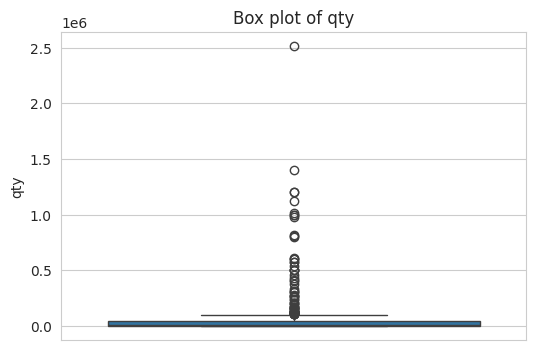

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df_raw['qty'])
plt.title('Box plot of qty')
plt.show()

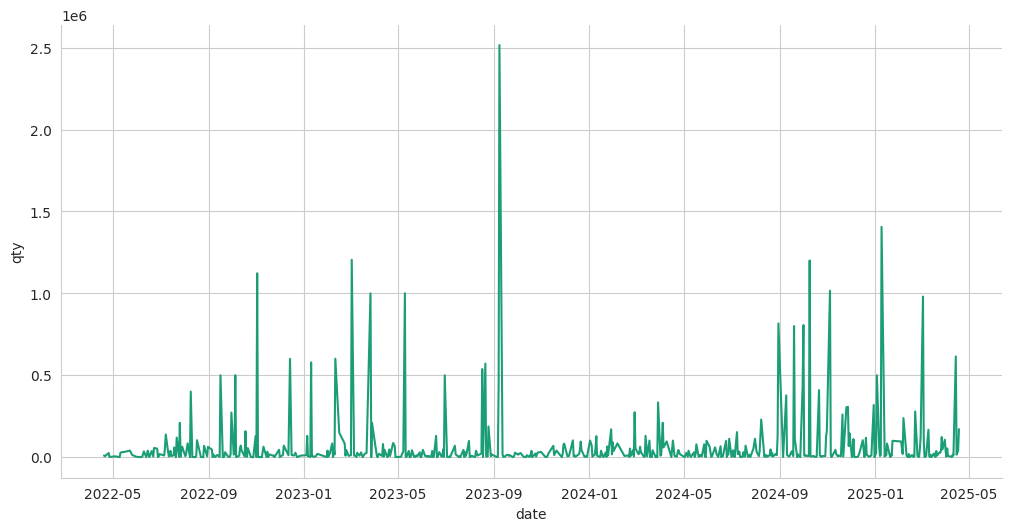

In [11]:
# @title date vs qty

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['qty']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_raw.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('qty')

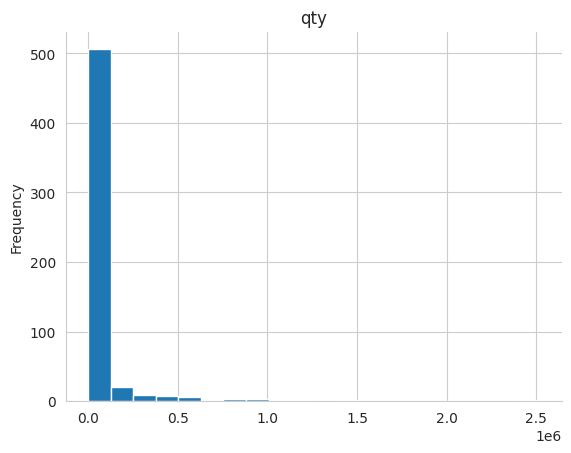

In [12]:
# @title qty

from matplotlib import pyplot as plt
df_raw['qty'].plot(kind='hist', bins=20, title='qty')
plt.gca().spines[['top', 'right',]].set_visible(False)

Số lượng ngoại lệ được xác định bằng IQR: 67
Các điểm ngoại lệ:


,date,qty
31,2022-07-08,137900
40,2022-07-22,119450
42,2022-07-26,209226
50,2022-08-09,400000
67,2022-09-16,500000
...,...,...
534,2025-03-10,166958
547,2025-03-27,122700
549,2025-03-31,106050
558,2025-04-14,614625



Số lượng giá trị thiếu sau nội suy: 0


/tmp/ipython-input-13-4139165590.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['qty'].interpolate(method='time', inplace=True)


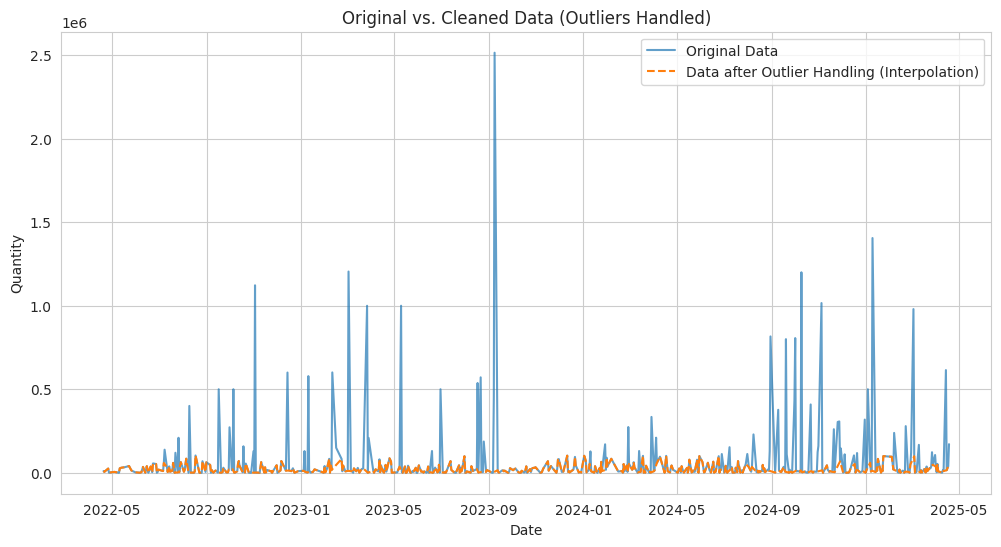

,date,qty
0,2022-04-20,10000.0
1,2022-04-21,5000.0
2,2022-04-26,25000.0
3,2022-04-27,700.0
4,2022-05-04,5000.0


In [13]:
# Xác định Q1, Q3 và IQR
Q1 = df_raw['qty'].quantile(0.25)
Q3 = df_raw['qty'].quantile(0.75)
IQR = Q3 - Q1

# Xác định ngưỡng dưới và ngưỡng trên
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các ngoại lệ
outliers = df_raw[(df_raw['qty'] < lower_bound) | (df_raw['qty'] > upper_bound)]

print(f"Số lượng ngoại lệ được xác định bằng IQR: {len(outliers)}")
print("Các điểm ngoại lệ:")
display(outliers)

# Thay thế ngoại lệ bằng NaN để chuẩn bị cho nội suy
df_cleaned = df_raw.copy()
df_cleaned.loc[outliers.index, 'qty'] = np.nan

# Đặt cột 'date' làm index trước khi nội suy theo thời gian
df_cleaned = df_cleaned.set_index('date')

# Nội suy các giá trị NaN (ngoại lệ đã được thay thế)
# Sử dụng method='time' vì dữ liệu có cột 'date'
df_cleaned['qty'].interpolate(method='time', inplace=True)

# Reset index về cột 'date'
df_cleaned = df_cleaned.reset_index()


# Kiểm tra lại xem còn giá trị NaN nào không sau nội suy
print(f"\nSố lượng giá trị thiếu sau nội suy: {df_cleaned['qty'].isnull().sum()}")

# Visual hóa dữ liệu sau khi xử lý ngoại lệ (so sánh với dữ liệu gốc nếu muốn)
plt.figure(figsize=(12, 6))
plt.plot(df_raw['date'], df_raw['qty'], label='Original Data', alpha=0.7)
plt.plot(df_cleaned['date'], df_cleaned['qty'], label='Data after Outlier Handling (Interpolation)', linestyle='--')
plt.title('Original vs. Cleaned Data (Outliers Handled)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Bây giờ bạn có thể sử dụng df_cleaned thay cho df_raw cho các bước tiếp theo (resampling, train/test split, modeling)
display(df_cleaned.head())

## 2. Pre‑processing

In [152]:
# Use df_cleaned after outlier handling
df_raw = df_cleaned
# Resample to monthly (change 'ME' if needed)
df = (df_raw.set_index('date')
       .resample('W') # Updated from 'M' to 'ME'
       .sum()
       .reset_index())
# Handle missing months
df['qty'] = df['qty'].fillna(0)
display(df.head(12))
print(f'Time span: {df.date.min().date()} → {df.date.max().date()}, {len(df)} periods')

,date,qty
0,2022-04-24,15000.00
1,2022-05-01,25700.00
2,2022-05-08,5000.00
3,2022-05-15,57620.00
4,2022-05-22,32700.00
5,2022-05-29,53670.00
6,2022-06-05,7500.00
7,2022-06-12,37869.00
8,2022-06-19,56345.00
9,2022-06-26,116160.00


Time span: 2022-04-24 → 2025-04-20, 157 periods


In [153]:
# Use last 24 months as test set
test_horizon = 31
train_df = df[:-test_horizon]
test_df  = df[-test_horizon:]
print(len(train_df), 'train ‖', len(test_df), 'test')

126 train ‖ 31 test


### 2.1 EDA – Trend & Seasonality

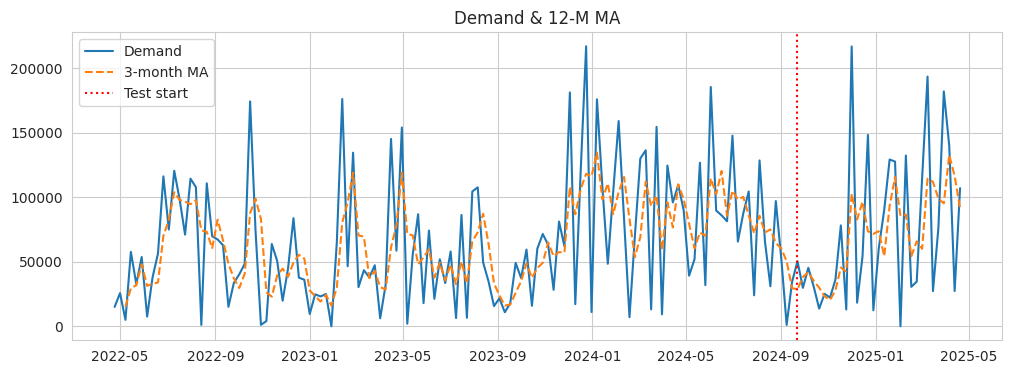

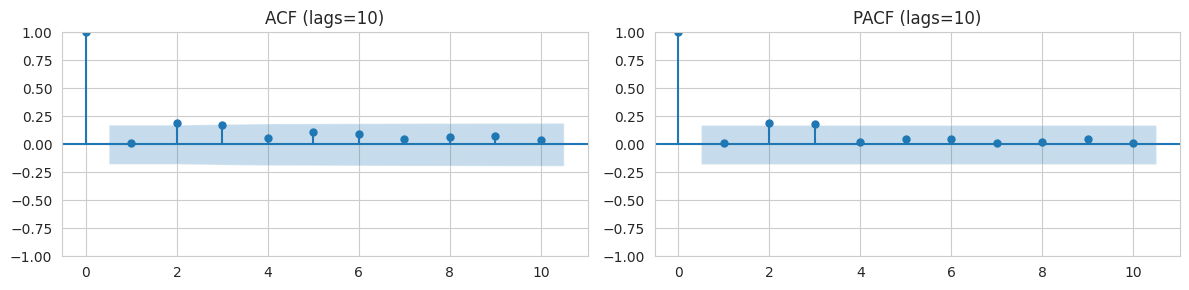

ADF p‑value: 0.00010785882167340215


In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plt.figure(figsize=(12,4))
plt.plot(df['date'], df['qty'], label='Demand')
plt.plot(df['date'], df['qty'].rolling(3).mean(), label='3‑month MA', linestyle='--')
plt.axvline(test_df.date.iloc[0], color='red', ls=':', label='Test start')
plt.legend(); plt.title('Demand & 12‑M MA'); plt.show()

# 1) Extract & clean
y = train_df['qty'].astype(float).replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
nobs = len(y)

# 2) Compute safe lags
max_acf_lag  = min(10, nobs - 1)        # you can ask up to nobs-1
max_pacf_lag = min(10, (nobs // 2) - 1) # must be < nobs//2

# guard in case your series is really short
max_pacf_lag = max(1, max_pacf_lag)

# 3) Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

plot_acf(y,  lags=max_acf_lag,  ax=axes[0])
plot_pacf(y, lags=max_pacf_lag, ax=axes[1])

axes[0].set_title(f"ACF (lags={max_acf_lag})")
axes[1].set_title(f"PACF (lags={max_pacf_lag})")

plt.tight_layout()
plt.show()

# Stationarity test
adf_res = adfuller(train_df['qty'])
print('ADF p‑value:', adf_res[1])

In [155]:
sma_window = 21
sma_forecast = train_df['qty'].rolling(sma_window).mean().iloc[-1]
sma_preds = np.repeat(sma_forecast, len(test_df))

## 3. Classical ARIMA

In [156]:
arima_model = pm.auto_arima(train_df['qty'],
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)
print(arima_model.summary())
arima_preds = arima_model.predict(n_periods=len(test_df))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3061.266, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3141.108, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3088.234, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3058.800, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3139.113, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3057.954, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3059.760, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3059.683, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3058.149, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3069.240, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3055.995, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3057.036, Time=0.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3086.234, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3057.771, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3057.762, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3056.203, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3067.243, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3059.321, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.078 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  126
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1524.998
Date:                Fri, 20 Jun 2025   AIC                           3055.995
Time:                        03:30:06   BIC                           3064.480
Sample:                             0   HQIC                          3059.442
                                - 126                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 4. Stand‑alone LSTM

In [157]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [158]:
def lstm_forecast(model, history, steps, scaler, seq_len):
    """
    model   : trained keras LSTM
    history : DataFrame or 1D array of the original (unscaled) series
    steps   : how many future points to predict
    scaler  : the scaler you fit on the train series
    seq_len : window length used to fit the LSTM
    """
    # 1) extract a 1D numpy array from history
    if hasattr(history, 'iloc'):
        hist_vals = history['qty'].values
    else:
        hist_vals = np.asarray(history).flatten()
    # 2) scale it
    hist_scaled = scaler.transform(hist_vals.reshape(-1,1))
    # 3) build your sliding window
    seq = hist_scaled[-seq_len:].reshape(1, seq_len, 1)
    preds = []
    for _ in range(steps):
        yhat = model.predict(seq, verbose=0)[0,0]
        preds.append(yhat)
        new_step = np.array(yhat).reshape(1,1,1)
        seq = np.concatenate([seq[:,1:,:], new_step], axis=1)
    return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()

In [159]:
# 1) Scale
scaler = MinMaxScaler()
train_vals = train_df[['qty']].values
test_vals  = test_df[['qty']].values
scaled_train = scaler.fit_transform(train_vals)
scaled_test  = scaler.transform(test_vals)

# 2) Tạo sequence
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i : i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

seq_len = 5
X_all, y_all = create_sequences(
    np.vstack([scaled_train, scaled_test]), seq_len
)

# 3) Split 80/20 cho train/val
split = int(len(X_all) * 0.8)
Xtr, Xval = X_all[:split], X_all[split:]
ytr, yval = y_all[:split], y_all[split:]

# 4) Reshape về (n_samples, seq_len, 1)
Xtr  = Xtr.reshape(-1, seq_len, 1)
Xval = Xval.reshape(-1, seq_len, 1)

# 5) Xây model chỉ LSTM
model = Sequential([
    LSTM(64, return_sequences=True,  input_shape=(seq_len,1)),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')

# 6) Train với EarlyStopping theo val_loss
# es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # EarlyStopping đã bị tắt
history = model.fit(
    Xtr, ytr,
    validation_data=(Xval, yval),
    epochs=150, batch_size=8,
    # callbacks=[es], # Bỏ callback EarlyStopping
    verbose=1
)

# 7) Forecast (tương tự hàm lstm_forecast trên)
lstm_preds = lstm_forecast(model, train_df, len(test_df), scaler, seq_len)

Epoch 1/150
16/16 [==============================] - 11s 120ms/step - loss: 0.2399 - val_loss: 0.2155
Epoch 2/150
16/16 [==============================] - 0s 16ms/step - loss: 0.1763 - val_loss: 0.2203
Epoch 3/150
16/16 [==============================] - 0s 17ms/step - loss: 0.1720 - val_loss: 0.2136
Epoch 4/150
16/16 [==============================] - 0s 17ms/step - loss: 0.1776 - val_loss: 0.2167
Epoch 5/150
16/16 [==============================] - 0s 17ms/step - loss: 0.1731 - val_loss: 0.2157
Epoch 6/150
16/16 [==============================] - 0s 16ms/step - loss: 0.1746 - val_loss: 0.2166
Epoch 7/150
16/16 [==============================] - 0s 16ms/step - loss: 0.1808 - val_loss: 0.2131
Epoch 8/150
16/16 [==============================] - 0s 16ms/step - loss: 0.1734 - val_loss: 0.2167
Epoch 9/150
16/16 [==============================] - 0s 16ms/step - loss: 0.1776 - val_loss: 0.2128
Epoch 10/150
16/16 [==============================] - 0s 17ms/step - loss: 0.1766 - val_loss: 0.21

## 5. Hybrid ARIMA + LSTM (Residual Learning)

In [110]:
from sklearn.preprocessing import MinMaxScaler

# 1) Fit scaler riêng cho residuals
residuals = train_df['qty'] - arima_model.predict_in_sample()
res_scaler = MinMaxScaler()
scaled_res = res_scaler.fit_transform(residuals.values.reshape(-1,1))

# 2) Tạo Xr, yr và train res_model như bạn đã làm
Xr, yr = create_sequences(scaled_res, seq_len)
Xr = Xr.reshape(-1, seq_len, 1)
res_model = models.Sequential([
    layers.LSTM(32, input_shape=(seq_len,1)),
    layers.Dense(1)
])
res_model.compile(optimizer='adam', loss='mse')
#es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
res_model.fit(Xr, yr, epochs=200, batch_size=16, verbose=0) # Bỏ callbacks=[es]

# 3) Forecast
base_preds = arima_model.predict(n_periods=len(test_df))
res_preds  = lstm_forecast(
    res_model,
    pd.DataFrame({'qty': residuals}),   # history của residuals
    len(test_df),                       # steps
    res_scaler,                         # scaler trên residuals
    seq_len                             # cùng seq_len khi train
)

hybrid_preds = base_preds + res_preds

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# @title Default title text
from sklearn.preprocessing import StandardScaler

# 1) Scaler zero-center trên residuals
residuals = train_df['qty'] - arima_model.predict_in_sample()
res_scaler = StandardScaler().fit(residuals.values.reshape(-1,1))
scaled_res  = res_scaler.transform(residuals.values.reshape(-1,1))

# 2) Nhỏ seq_len + units LSTM
seq_len = 3 # Giữ nguyên seq_len = 3 từ cell trước
Xr, yr = create_sequences(scaled_res, seq_len)
Xr = Xr.reshape(-1, seq_len, 1)

res_model = Sequential([
    LSTM(16, input_shape=(seq_len,1)),  # chỉ còn 16 units
    Dense(1)
])
res_model.compile('adam', 'mse')
#es = EarlyStopping(patience=50, restore_best_weights=True) # Giữ nguyên định nghĩa es nhưng không dùng
res_model.fit(Xr, yr, epochs=100, batch_size=4, verbose=0) # Bỏ callbacks=[es]

# 3) Forecast dùng helper (truyền array cho history)
scaled_arr = scaled_res.flatten()
res_preds = lstm_forecast(res_model, scaled_arr, len(test_df), res_scaler, seq_len)
hybrid_preds = base_preds + res_preds # base_preds từ ARIMA trước đó

In [ ]:
# @title Default title text
# 1) Scaler về [-1,1]
res_scaler = MinMaxScaler(feature_range=(-1,1)).fit(residuals.values.reshape(-1,1))
scaled_res = res_scaler.transform(residuals.values.reshape(-1,1))

# 2) Tạo Xr bình thường, nhưng Dense cuối có output = n_test
# Sử dụng seq_len = 3 như trong cell trước
seq_len = 3
n_test = len(test_df) # Đảm bảo n_test được định nghĩa

Xr, yr = create_sequences(scaled_res, seq_len)
Xr = Xr.reshape(-1, seq_len, 1)

# biến yr thành multi-step (mỗi sample tương ứng toàn bộ future window)
# Cần kiểm tra lại logic tạo yr_multi cho đúng với multi-step output
# Tạm thời bỏ qua yr_multi trong fit nếu mô hình dự báo multi-step trực tiếp
# mà không cần target multi-step trong train data creation

model_ms = Sequential([
    LSTM(32, input_shape=(seq_len,1)),
    Dense(n_test)      # output thẳng n_test bước
])
model_ms.compile('adam','mse')
#res_model.fit(Xr[:len(yr_multi)], yr_multi, epochs=100, batch_size=4, verbose=0) # Fit với yr_multi có thể phức tạp hơn

# Thay đổi: Chỉ fit model_ms với Xr và yr single step như bình thường,
# nhưng sử dụng kiến trúc Dense(n_test) để nó học ánh xạ từ sequence input
# sang n_test output. Hàm create_sequences ban đầu chỉ tạo yr single step.
# Để train mô hình multi-step trực tiếp đúng nghĩa, yr phải là vector n_test.
# Nếu dữ liệu ngắn, việc tạo yr_multi có thể không đủ sample.
# Cách đơn giản nhất là fit với Xr, yr single step, và hy vọng Dense(n_test) học tốt.
# Hoặc chỉ sử dụng cách 1 & 2 với dự báo single-step lặp.

# Để cell này chạy được (với cảnh báo về EarlyStopping đã tắt),
# chúng ta sẽ fit với Xr và yr single step, mặc dù kiến trúc Dense(n_test)
# ngụ ý multi-step. Đây có thể là lý do ban đầu có nhiều cách thử.

# Fit với Xr và yr single-step
res_model_ms = Sequential([
    LSTM(32, input_shape=(seq_len,1)),
    Dense(n_test)
])
res_model_ms.compile('adam','mse')
#es = EarlyStopping(patience=50, restore_best_weights=True) # Giữ nguyên định nghĩa es nhưng không dùng
res_model_ms.fit(Xr, yr, epochs=100, batch_size=4, verbose=0) # Bỏ callbacks=[es]

# 3) Forecast one-shot
# Sử dụng res_model_ms vừa fit
res_preds_ms = res_model_ms.predict(Xr[-1:].reshape(1,seq_len,1))[0] # Lấy dự báo multi-step
res_preds = res_scaler.inverse_transform(res_preds_ms.reshape(-1,1)).flatten() # Inverse transform kết quả multi-step

hybrid_preds_ms = base_preds + res_preds # base_preds từ ARIMA trước đó

# Cập nhật biến hybrid_preds để sử dụng kết quả từ cách này nếu muốn so sánh
hybrid_preds = hybrid_preds_ms

# In kết quả dự báo residual và hybrid từ cách này
print("Predicted residuals (Multi-step):", res_preds)
print("Min/Max predicted residuals (Multi-step):", np.min(res_preds), np.max(res_preds))
print("Hybrid preds (Multi-step):", hybrid_preds_ms)

1/1 [==============================] - 0s 490ms/step
Predicted residuals (Multi-step): [2684.8022  2225.7969  1514.7971  1576.4479   542.55896  879.9356
 1149.624    962.6075  1420.3616   794.3078   285.80115  579.5603
 1997.0415  1673.6708  1416.9524  1678.9045   290.89813 1489.0219
 1733.1262   613.4053  1980.6847  1243.6288  2476.169   1505.6709
 1284.4327  1072.2458   957.03284 1626.9363   615.1755  2554.995
  401.44135]
Min/Max predicted residuals (Multi-step): 285.80115 2684.8022
Hybrid preds (Multi-step): 126    62231.586103
127    56889.197310
128    57125.886256
129    57003.624795
130    56005.426611
131    56335.876974
132    56606.909532
133    56419.632142
134    56877.436853
135    56251.373257
136    55742.868511
137    56036.627296
138    57454.108569
139    57130.737828
140    56874.019447
141    57135.971594
142    55747.965186
143    56946.088904
144    57190.193274
145    56070.472327
146    57437.751746
147    56700.695838
148    57933.235999
149    56962.737952
15

## 6. Evaluation

In [111]:
# 1️⃣ Tạo hàm đánh giá
def mae_rmse(y_true, y_pred):
    y_true, y_pred = map(np.asarray, (y_true, y_pred))
    # cắt cho cùng độ dài
    n = min(y_true.size, y_pred.size)
    yt, yp = y_true[:n].flatten(), y_pred[:n].flatten()
    mask = ~np.isnan(yt) & ~np.isnan(yp)
    if mask.sum() == 0:
        return np.nan, np.nan
    return (mean_absolute_error(yt[mask], yp[mask]),
            np.sqrt(mean_squared_error(yt[mask], yp[mask])))

# 2️⃣ Chạy đánh giá
results = {}
for name, preds in [
    ('MA',  sma_preds),
    ('ARIMA',  arima_preds),
    ('LSTM',   lstm_preds),
    ('Hybrid', hybrid_preds),
]:
    mae, rmse = mae_rmse(test_df['qty'], preds)
    results[name] = {'MAE': mae, 'RMSE': rmse}

results_df = pd.DataFrame(results).T
display(results_df)

,MAE,RMSE
MA,51385.828136,59273.959229
ARIMA,48246.459917,61727.431187
LSTM,47572.909921,63687.309640
Hybrid,48567.311089,60640.838274


In [112]:
def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).mean() * 100

# Tính MAPE cho từng model
scores = {}
for name, preds in [
    ('MA',    sma_preds),
    ('ARIMA',  arima_preds),
    ('LSTM',   lstm_preds),
    ('Hybrid', hybrid_preds)
]:
    scores[name] = mape(test_df['qty'], preds)

pd.Series(scores, name='MAPE (%)').round(2)

,MAPE (%)
MA,133.04
ARIMA,92.44
LSTM,80.48
Hybrid,99.90


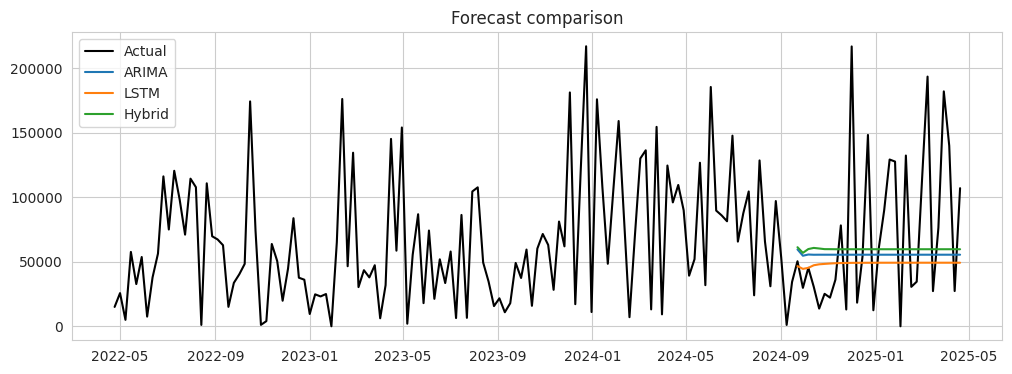

In [113]:
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['qty'], label='Actual', c='black')
plt.plot(test_df['date'], arima_preds, label='ARIMA')
plt.plot(test_df['date'], lstm_preds, label='LSTM')
plt.plot(test_df['date'], hybrid_preds, label='Hybrid')
plt.legend(); plt.title('Forecast comparison'); plt.show()

In [114]:
# 1) Tính residuals
arima_fitted = arima_model.predict_in_sample()
residuals   = train_df['qty'] - arima_fitted

# 2) Xem mô tả thống kê
print("Residuals phân phối:")
print(residuals.describe())

# 3) Sau khi forecast, in luôn res_preds
res_preds = lstm_forecast(
    res_model,
    pd.DataFrame({'qty': residuals}),
    len(test_df),
    res_scaler,    # chắc bạn phải tạo res_scaler riêng cho residuals
    seq_len
)
print("Predicted residuals:", res_preds)
print("Min/Max predicted residuals:", np.min(res_preds), np.max(res_preds))

# 4) Cuối cùng
hybrid_preds = base_preds + res_preds
print("Hybrid preds:", hybrid_preds)

Residuals phân phối:
count       126.000000
mean       2087.456171
std       47839.020534
min     -101314.418973
25%      -30233.253779
50%       -2836.420340
75%       29534.284237
max      150102.383759
dtype: float64
Predicted residuals: [1724.015  2235.841  4232.861  5298.2104 4814.8047 4322.6846 4298.588
 4251.608  4233.1455 4240.1064 4246.2583 4246.85   4247.7793 4248.0938
 4248.004  4247.944  4247.914  4247.899  4247.899  4247.9062 4247.9062
 4247.9062 4247.9062 4247.9062 4247.9062 4247.9062 4247.9062 4247.9062
 4247.9062 4247.9062 4247.9062]
Min/Max predicted residuals: 1724.015 5298.2104
Hybrid preds: 126    61270.798871
127    56899.241500
128    59843.949976
129    60725.387368
130    60277.672339
131    59778.625937
132    59755.873399
133    59708.632569
134    59690.220789
135    59697.171902
136    59703.325664
137    59703.917091
138    59704.846362
139    59705.160801
140    59705.070960
141    59705.010901
142    59704.981116
143    59704.965979
144    59704.965979
14

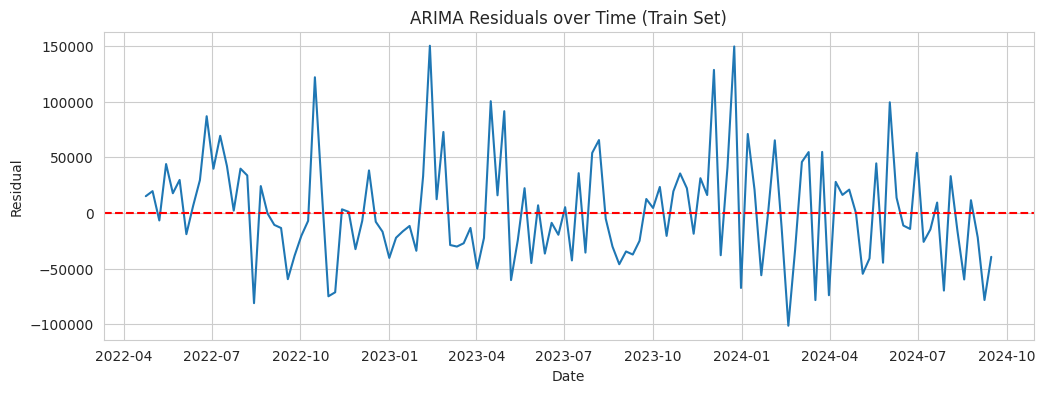

In [115]:
plt.figure(figsize=(12, 4))
plt.plot(train_df['date'], residuals)
plt.title('ARIMA Residuals over Time (Train Set)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--') # Đường tham chiếu tại 0
plt.show()

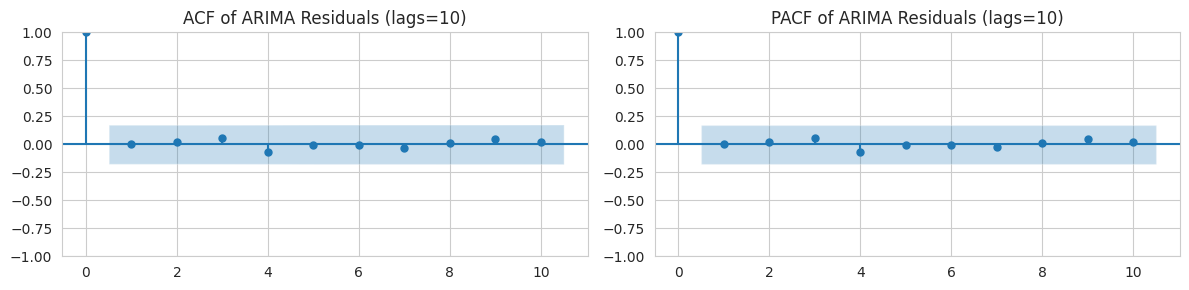

In [116]:
# Compute safe lags for residuals ACF/PACF
nobs_res = len(residuals)
max_acf_lag_res  = min(10, nobs_res - 1)
max_pacf_lag_res = min(10, (nobs_res // 2) - 1)
max_pacf_lag_res = max(1, max_pacf_lag_res)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

plot_acf(residuals,  lags=max_acf_lag_res,  ax=axes[0])
plot_pacf(residuals, lags=max_pacf_lag_res, ax=axes[1])

axes[0].set_title(f"ACF of ARIMA Residuals (lags={max_acf_lag_res})")
axes[1].set_title(f"PACF of ARIMA Residuals (lags={max_pacf_lag_res})")

plt.tight_layout()
plt.show()

## 7. Conclusion
The hybrid model often captures both linear and nonlinear signals by stacking LSTM on ARIMA residuals. Review the metrics above to see which model wins. Extend the notebook by tuning hyper‑parameters, adding cross‑validation, or simulating inventory impact.

In [117]:
# ─── 6. Extended Forecast Comparison ───────────────────────────────────────────────
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import (
    SimpleExpSmoothing,    # SES
    Holt,                  # Double ES (Holt’s linear)
    ExponentialSmoothing   # Holt–Winters
)
import pmdarima as pm

# assume train_df['qty'] and test_df['qty'] are already defined
n_test = len(test_df)

# 1) Single Exponential Smoothing (SES)
ses = SimpleExpSmoothing(train_df['qty']).fit(optimized=True)
ses_preds = ses.forecast(n_test)

# 2) Double Exponential Smoothing (Holt’s Linear)
holt = Holt(train_df['qty']).fit(optimized=True)
holt_preds = holt.forecast(n_test)

# 3) Holt–Winters Additive Seasonal (m=12)
# Check if train_df is long enough for seasonal_periods=12
# A common heuristic is min 2*seasonal_periods or more data points.
# If train_df has fewer than 24 points, seasonal_periods=12 might be problematic.
seasonal_periods_hw = 12 # Assuming monthly seasonality
if len(train_df) < 2 * seasonal_periods_hw:
    print(f"Warning: Training data ({len(train_df)}) may be too short for Holt-Winters seasonal_periods={seasonal_periods_hw}. Skipping seasonal models.")
    hw_add_preds = pd.Series(np.nan, index=test_df.index) # Fill with NaN if skipped
    hw_mul_preds = pd.Series(np.nan, index=test_df.index) # Fill with NaN if skipped
else:
    try:
        hw_add = ExponentialSmoothing(
            train_df['qty'],
            trend='add',
            seasonal='add',
            seasonal_periods=seasonal_periods_hw
        ).fit(optimized=True)
        hw_add_preds = hw_add.forecast(n_test)
        print("Holt-Winters Additive model fitted and forecasted.")
    except Exception as e:
        print(f"Error fitting Holt-Winters Additive model: {e}. Skipping.")
        hw_add_preds = pd.Series(np.nan, index=test_df.index) # Fill with NaN if failed

    # 4) Holt–Winters Multiplicative Seasonal
    # This model requires strictly positive data. Skip if there are zeros or negatives.
    if (train_df['qty'] <= 0).any():
        print("Skipping Holt-Winters Multiplicative model due to non-positive values in training data.")
        hw_mul_preds = pd.Series(np.nan, index=test_df.index) # Fill with NaN if skipped
    else:
        try:
            hw_mul = ExponentialSmoothing(
                train_df['qty'],
                trend='add', # You might also try trend='mul' if appropriate
                seasonal='mul',
                seasonal_periods=seasonal_periods_hw
            ).fit(optimized=True)
            hw_mul_preds = hw_mul.forecast(n_test)
            print("Holt-Winters Multiplicative model fitted and forecasted.")
        except Exception as e:
             print(f"Error fitting Holt-Winters Multiplicative model: {e}. Skipping.")
             hw_mul_preds = pd.Series(np.nan, index=test_df.index) # Fill with NaN if failed


# 5) SARIMA tự động (pmdarima)
# Check if train_df is long enough for seasonal_periods=12
# pmdarima handles short data better, but still good practice to check
seasonal_m_sarima = 12
if len(train_df) < seasonal_m_sarima + 1: # Minimum length is generally m+1 for seasonal models
    print(f"Warning: Training data ({len(train_df)}) may be too short for SARIMA m={seasonal_m_sarima}. Skipping auto_arima.")
    sarima_auto = None
    sarima_preds = pd.Series(np.nan, index=test_df.index) # Fill with NaN if skipped
else:
    try:
        sarima_auto = pm.auto_arima(
            train_df['qty'],
            seasonal=True,    # bật seasonal
            m=seasonal_m_sarima,             # chu kỳ mùa (monthly data)
            trace=False,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        sarima_preds = sarima_auto.predict(n_periods=n_test)
        print("SARIMA Auto model fitted and forecasted.")
    except Exception as e:
        print(f"Error fitting SARIMA Auto model: {e}. Skipping.")
        sarima_auto = None
        sarima_preds = pd.Series(np.nan, index=test_df.index) # Fill with NaN if failed


# 6) SARIMAX thủ công (ví dụ (1,0,1)(1,1,1,12))
# Need to re-evaluate order based on new data if applicable
# Example order (1,0,1)(1,1,1,12) might not be optimal for new data
sarimax_order = (1,0,1)
sarimax_seasonal_order = (1,1,1,12)
if len(train_df) < sarimax_seasonal_order[3] + sarimax_seasonal_order[1]: # Minimal check for seasonal differencing
    print(f"Warning: Training data ({len(train_df)}) may be too short for SARIMAX seasonal_order={sarimax_seasonal_order}. Skipping manual SARIMAX.")
    sarimax = None
    sarimax_preds = pd.Series(np.nan, index=test_df.index) # Fill with NaN if skipped
else:
    try:
        # Make sure to use train_df['qty'] from the current run (new data)
        sarimax = sm.tsa.statespace.SARIMAX(
            train_df['qty'],
            order=sarimax_order,
            seasonal_order=sarimax_seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        sarimax_preds = sarimax.get_forecast(steps=n_test).predicted_mean
        print("SARIMAX Manual model fitted and forecasted.")
    except Exception as e:
        print(f"Error fitting SARIMAX Manual model: {e}. Skipping.")
        sarimax = None
        sarimax_preds = pd.Series(np.nan, index=test_df.index) # Fill with NaN if failed


# 7) (optional) ARIMA, LSTM, Hybrid if you have them defined from earlier cells:
# Make sure these variables exist and contain forecasts based on the NEW data's train/test split
# arima_preds  = ... # Ensure this is the ARIMA forecast on NEW data
# lstm_preds   = ... # Ensure this is the LSTM forecast on NEW data
# hybrid_preds = ... # Ensure this is the Hybrid forecast on NEW data


# 8) Gom tất cả vào DataFrame để so sánh
forecasts = pd.DataFrame({
    'SES':        ses_preds, # SES preds are Series already
    'Holt':       holt_preds, # Holt preds are Series already
    'HW_add':     hw_add_preds, # HW_add preds are Series or NaN Series
    'HW_mul':     hw_mul_preds, # HW_mul preds are Series or NaN Series
    'SARIMA_PM':  sarima_preds, # SARIMA_PM preds are Series or NaN Series
    'SARIMAX_SM': sarimax_preds, # SARIMAX_SM preds are Series or NaN Series
    # Add other forecasts if you have them for the new data
    # 'ARIMA':      arima_preds,
    # 'LSTM':       lstm_preds,
    # 'Hybrid':     hybrid_preds
}, index=test_df.index) # Use test_df index to align forecasts

# Hiển thị kết quả
print("\nForecasts from Extended Models (first 5 rows):")
display(forecasts.head())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_a

Holt-Winters Additive model fitted and forecasted.
Skipping Holt-Winters Multiplicative model due to non-positive values in training data.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

SARIMA Auto model fitted and forecasted.
SARIMAX Manual model fitted and forecasted.

Forecasts from Extended Models (first 5 rows):


,SES,Holt,HW_add,HW_mul,SARIMA_PM,SARIMAX_SM
126,63844.508235,44780.985033,82505.961319,NaN,59546.783857,81931.368279
127,63844.508235,40595.659830,51014.337352,NaN,54663.400435,85924.465958
128,63844.508235,36410.334626,74577.630912,NaN,55611.089137,87980.593567
129,63844.508235,32225.009423,61179.191237,NaN,55427.176919,81569.593140
130,63844.508235,28039.684220,42342.801225,NaN,55462.867651,87189.423526


In [118]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

kpis = {}
y_true = test_df['qty'].values

for method in forecasts.columns:
    y_pred = forecasts[method].values

    # Check if the forecast column contains only NaN values
    if forecasts[method].isnull().all():
        print(f"Skipping metrics calculation for '{method}' as forecast contains only NaN.")
        kpis[method] = {
            'MAE': np.nan,
            'RMSE': np.nan,
            'MAPE (%)': np.nan
        }
        continue # Skip to the next method

    # For cases where there are some NaNs but not all (e.g., if a model partially failed or produced NaNs)
    # We need to handle NaNs in both y_true and y_pred before calculation.
    # A simple approach for evaluation is to drop corresponding values if either is NaN.
    # However, dropping values changes the length of the series being compared, which might not be ideal.
    # Let's assume valid forecasts should not have NaNs in the evaluation period for now,
    # except for cases where the entire forecast for a model is NaN (handled above).
    # If models *can* produce sparse NaNs, a more robust approach is needed (e.g., filtering).

    # Ensure y_true does not have zeros for MAPE calculation
    y_true_clean = y_true[y_true != 0]
    y_pred_clean = y_pred[y_true != 0]

    # Also handle potential NaNs in y_pred_clean if the model produced some NaNs
    # Filter out NaNs from both y_true_clean and y_pred_clean simultaneously
    valid_indices = ~np.isnan(y_pred_clean) # Check NaNs in y_pred_clean after filtering zeros from y_true
    y_true_final = y_true_clean[valid_indices]
    y_pred_final = y_pred_clean[valid_indices]


    # Check if there are any valid points left for calculation
    if len(y_true_final) == 0:
         print(f"Skipping metrics calculation for '{method}' due to no valid non-zero actual values or all predicted values being NaN.")
         kpis[method] = {
            'MAE': np.nan,
            'RMSE': np.nan,
            'MAPE (%)': np.nan
        }
         continue # Skip to the next method


    # 1) MAE
    mae = mean_absolute_error(y_true_final, y_pred_final)

    # 2) RMSE
    rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))

    # 3) MAPE
    # Use the existing mape function or the manual calculation, ensuring no division by zero.
    # The manual calculation below is equivalent to the mape function if y_true_final has no zeros.
    mape_score = np.mean(np.abs((y_true_final - y_pred_final) / y_true_final)) * 100


    kpis[method] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape_score
    }

kpi_df = pd.DataFrame(kpis).T
print("\nKPIs for Extended Models:")
display(kpi_df.round(2))

Skipping metrics calculation for 'HW_mul' as forecast contains only NaN.

KPIs for Extended Models:


,MAE,RMSE,MAPE (%)
SES,48675.82,59722.43,107.58
Holt,94811.66,123958.45,124.77
HW_add,53081.52,70203.67,94.76
HW_mul,NaN,NaN,NaN
SARIMA_PM,48006.11,61925.51,92.44
SARIMAX_SM,52706.21,59164.11,158.03


In [119]:
ma_preds  = sma_preds        # đấy chính là moving-average 12
hyb_preds = hybrid_preds     # ARIMA+LSTM residuals

In [120]:
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.stats import norm

# 0) Gán đúng biến
ma_preds  = sma_preds
hyb_preds = hybrid_preds

# 1) Tính MAPE point-wise
y_true   = test_df['qty'].values
ma_err   = np.abs((y_true - ma_preds)  / y_true)
hy_err   = np.abs((y_true - hyb_preds) / y_true)

# 2) Loss differential d_t
d = ma_err - hy_err

# 3) Ước lượng long‐run variance S
h   = 1   # one‐step forecast
rho = acf(d, fft=False, nlags=h)    # [ρ₀, ρ₁]
var_d = np.var(d, ddof=1)
S = rho[0]*var_d + 2 * rho[1]*var_d

# 4) DM statistic và p-value
dm_stat = d.mean() / np.sqrt(S/len(d))
p_value = 2 * (1 - norm.cdf(abs(dm_stat)))

print(f"DM‐statistic = {dm_stat:.3f}, p‐value = {p_value:.3f}")

DM‐statistic = nan, p‐value = nan


/tmp/ipython-input-120-3124791962.py:11: RuntimeWarning: divide by zero encountered in divide
  ma_err   = np.abs((y_true - ma_preds)  / y_true)


In [121]:
from scipy.stats import wilcoxon, ttest_rel

# Giả sử ma_err, hy_err đã có
w_stat, w_p = wilcoxon(ma_err, hy_err)
t_stat, t_p = ttest_rel(ma_err, hy_err)

print("Wilcoxon p-value:", w_p)
print("Paired t-test p-value:", t_p)

Wilcoxon p-value: 0.0027663204818964005
Paired t-test p-value: nan


/usr/local/lib/python3.11/dist-packages/scipy/stats/_wilcoxon.py:66: RuntimeWarning: invalid value encountered in subtract
  d = x - y
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:7037: RuntimeWarning: invalid value encountered in subtract
  return ttest_1samp(a - b, popmean=0, axis=axis, alternative=alternative,


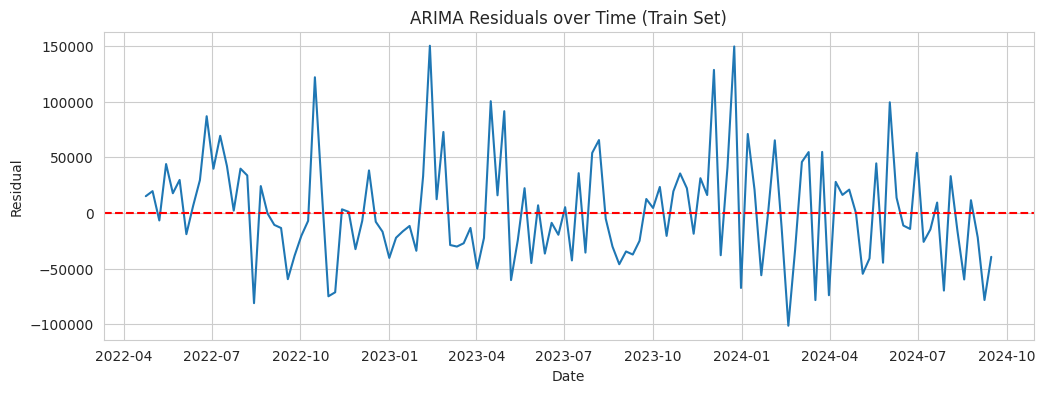

In [122]:
plt.figure(figsize=(12, 4))
plt.plot(train_df['date'], residuals)
plt.title('ARIMA Residuals over Time (Train Set)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--') # Đường tham chiếu tại 0
plt.show()

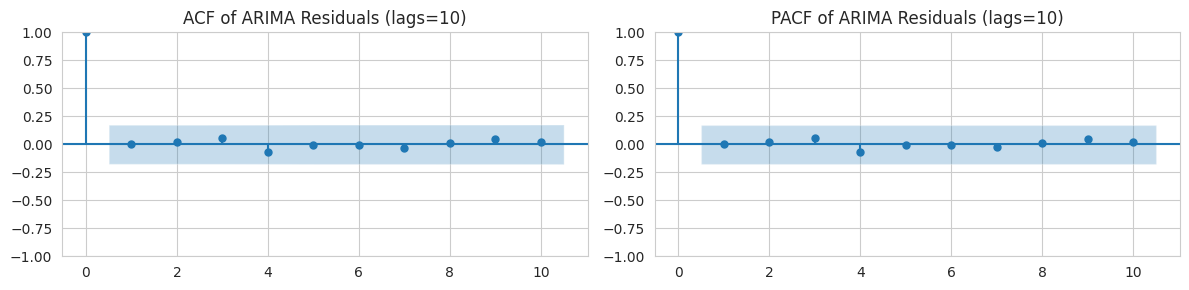

In [123]:
# Compute safe lags for residuals ACF/PACF
nobs_res = len(residuals)
max_acf_lag_res  = min(10, nobs_res - 1)
max_pacf_lag_res = min(10, (nobs_res // 2) - 1)
max_pacf_lag_res = max(1, max_pacf_lag_res)

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

plot_acf(residuals,  lags=max_acf_lag_res,  ax=axes[0])
plot_pacf(residuals, lags=max_pacf_lag_res, ax=axes[1])

axes[0].set_title(f"ACF of ARIMA Residuals (lags={max_acf_lag_res})")
axes[1].set_title(f"PACF of ARIMA Residuals (lags={max_pacf_lag_res})")

plt.tight_layout()
plt.show()

LSTM Forecasting Errors (Test Set) Description:
count        31.000000
mean      24455.708512
std       59776.735620
min      -49247.375000
25%      -21967.667969
50%        3762.978906
75%       72083.369922
max      167724.625558
Name: qty, dtype: float64


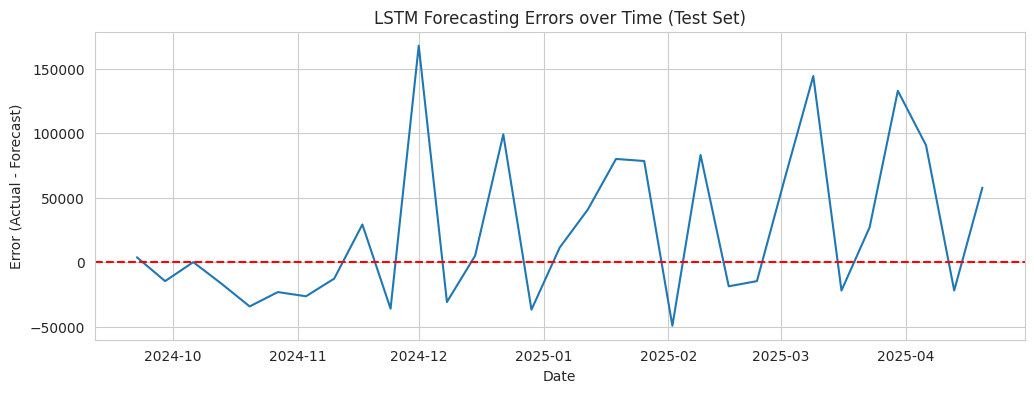

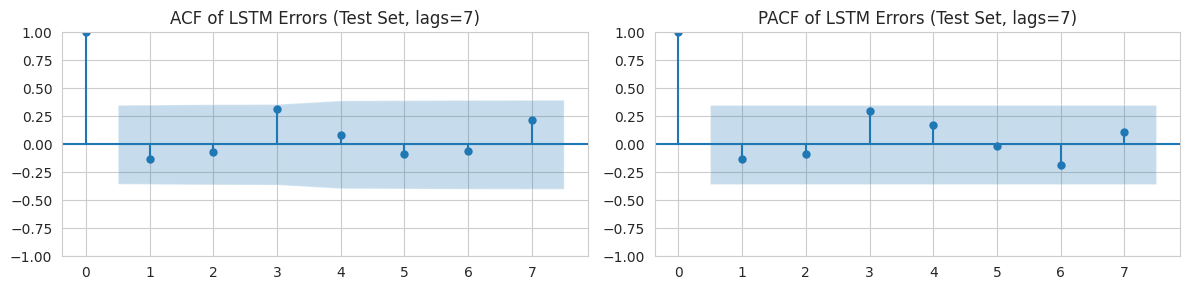

In [125]:
# Calculate forecasting errors for LSTM on test set
lstm_errors = test_df['qty'] - lstm_preds

print("LSTM Forecasting Errors (Test Set) Description:")
print(lstm_errors.describe())

# Visualize LSTM forecasting errors over time (Test Set)
plt.figure(figsize=(12, 4))
plt.plot(test_df['date'], lstm_errors)
plt.title('LSTM Forecasting Errors over Time (Test Set)')
plt.xlabel('Date')
plt.ylabel('Error (Actual - Forecast)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Compute safe lags for error analysis
nobs_errors = len(lstm_errors)
max_acf_lag_errors  = min(7, nobs_errors - 1) # Max lags <= test set size
max_pacf_lag_errors = min(7, (nobs_errors // 2) - 1)
max_pacf_lag_errors = max(1, max_pacf_lag_errors)


# Plot ACF and PACF of LSTM forecasting errors (Test Set)
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

plot_acf(lstm_errors,  lags=max_acf_lag_errors,  ax=axes[0])
plot_pacf(lstm_errors, lags=max_pacf_lag_errors, ax=axes[1])

axes[0].set_title(f"ACF of LSTM Errors (Test Set, lags={max_acf_lag_errors})")
axes[1].set_title(f"PACF of LSTM Errors (Test Set, lags={max_pacf_lag_errors})")

plt.tight_layout()
plt.show()


SARIMAX Forecasting Errors (Test Set) Description:
count        31.000000
mean     -16970.897279
std       58785.652648
min      -87116.007007
25%      -60163.486222
50%      -41020.697029
75%       26640.702452
max      122665.644581
dtype: float64


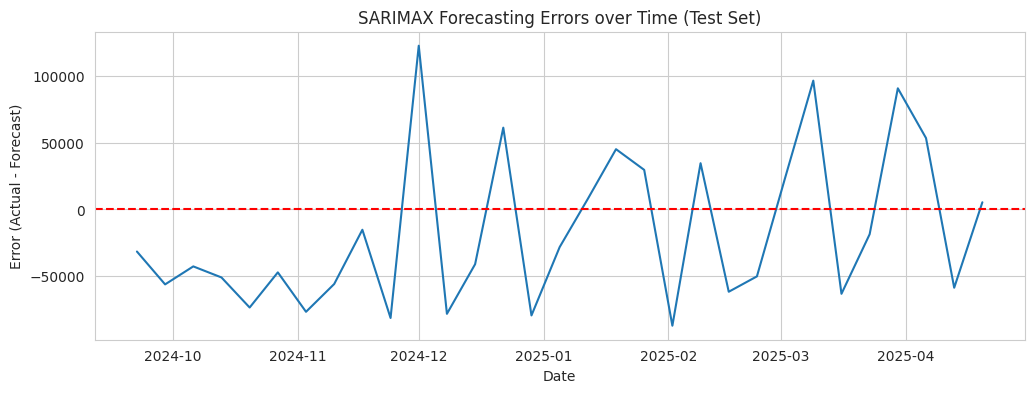

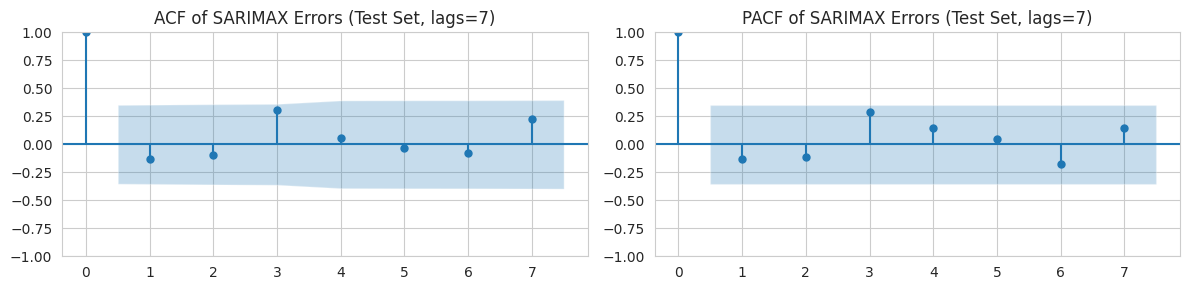

In [126]:
# Calculate forecasting errors for SARIMAX on test set
# Use the SARIMAX model defined in cell AjZHzuirqRuH
# Ensure the model object 'sarimax' is available from previous runs
try:
    sarimax_errors = test_df['qty'] - sarimax_preds
except NameError:
    print("SARIMAX model ('sarimax') or predictions ('sarimax_preds') not found. Please run the SARIMAX cell (AjZHzuirqRuH) first.")

if 'sarimax_errors' in locals():
    print("\nSARIMAX Forecasting Errors (Test Set) Description:")
    print(sarimax_errors.describe())

    # Visualize SARIMAX forecasting errors over time (Test Set)
    plt.figure(figsize=(12, 4))
    plt.plot(test_df['date'], sarimax_errors)
    plt.title('SARIMAX Forecasting Errors over Time (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Error (Actual - Forecast)')
    plt.axhline(0, color='red', linestyle='--')
    plt.show()

    # Compute safe lags for error analysis (same logic as before, limited by test set size)
    nobs_errors_sarimax = len(sarimax_errors)
    max_acf_lag_errors_sarimax  = min(7, nobs_errors_sarimax - 1)
    max_pacf_lag_errors_sarimax = min(7, (nobs_errors_sarimax // 2) - 1)
    max_pacf_lag_errors_sarimax = max(1, max_pacf_lag_errors_sarimax)


    # Plot ACF and PACF of SARIMAX forecasting errors (Test Set)
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    plot_acf(sarimax_errors,  lags=max_acf_lag_errors_sarimax,  ax=axes[0])
    plot_pacf(sarimax_errors, lags=max_pacf_lag_errors_sarimax, ax=axes[1])

    axes[0].set_title(f"ACF of SARIMAX Errors (Test Set, lags={max_acf_lag_errors_sarimax})")
    axes[1].set_title(f"PACF of SARIMAX Errors (Test Set, lags={max_pacf_lag_errors_sarimax})")

    plt.tight_layout()
    plt.show()

# Task
Thêm code để xây dựng và đánh giá mô hình Hybrid SARIMA + LSTM.

## Tính toán sarima residuals

### Subtask:
Sử dụng mô hình SARIMA (hoặc SARIMAX) đã fit trên tập train để tính toán residuals (sai số dự báo trong tập huấn luyện).


**Reasoning**:
Calculate the SARIMAX residuals on the training set by subtracting the fitted values from the actual values.



In [127]:
# Calculate SARIMAX residuals on the training set
# Ensure sarimax model is available
try:
    sarimax_fitted = sarimax.fittedvalues
    sarimax_residuals = train_df['qty'] - sarimax_fitted

    print("SARIMAX Residuals (Train Set) Description:")
    print(sarimax_residuals.describe())

except NameError:
    print("SARIMAX model ('sarimax') not found. Please run the SARIMAX cell (AjZHzuirqRuH) first.")


SARIMAX Residuals (Train Set) Description:
count       126.000000
mean       9609.915439
std       49502.608464
min      -83253.205588
25%      -30377.731109
50%        3736.923262
75%       38588.441821
max      147980.173574
dtype: float64


**Reasoning**:
Visualize the SARIMAX residuals over time and plot the ACF and PACF to check for remaining patterns.



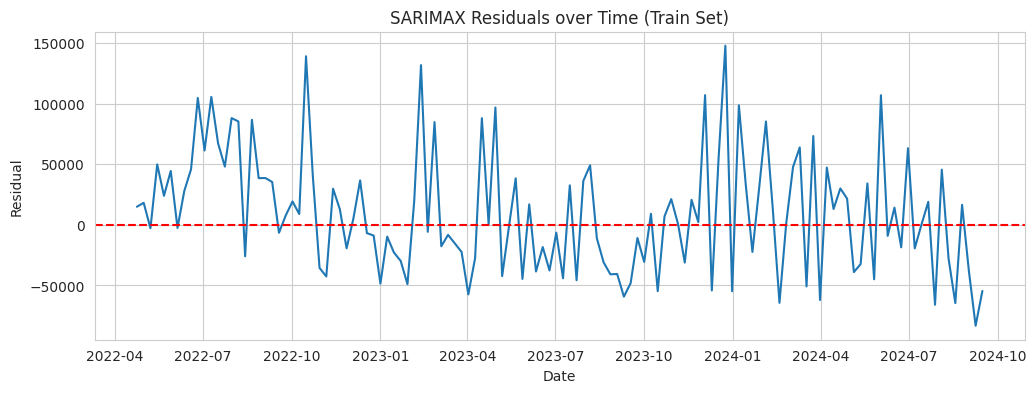

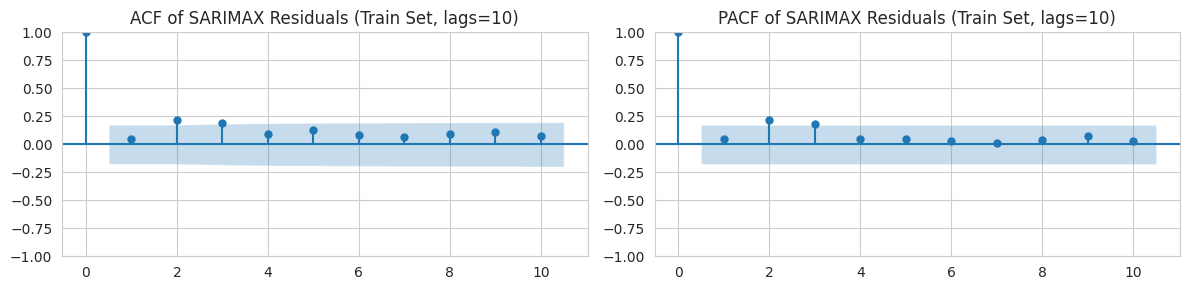

In [128]:
# Visualize SARIMAX residuals over time (Train Set)
if 'sarimax_residuals' in locals():
    plt.figure(figsize=(12, 4))
    plt.plot(train_df['date'], sarimax_residuals)
    plt.title('SARIMAX Residuals over Time (Train Set)')
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.axhline(0, color='red', linestyle='--') # Reference line at 0
    plt.show()

    # Compute safe lags for residual analysis
    nobs_res_sarimax = len(sarimax_residuals)
    max_acf_lag_res_sarimax  = min(10, nobs_res_sarimax - 1)
    max_pacf_lag_res_sarimax = min(10, (nobs_res_sarimax // 2) - 1)
    max_pacf_lag_res_sarimax = max(1, max_pacf_lag_res_sarimax)

    # Plot ACF and PACF of SARIMAX residuals (Train Set)
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    plot_acf(sarimax_residuals,  lags=max_acf_lag_res_sarimax,  ax=axes[0])
    plot_pacf(sarimax_residuals, lags=max_pacf_lag_res_sarimax, ax=axes[1])

    axes[0].set_title(f"ACF of SARIMAX Residuals (Train Set, lags={max_acf_lag_res_sarimax})")
    axes[1].set_title(f"PACF of SARIMAX Residuals (Train Set, lags={max_pacf_lag_res_sarimax})")

    plt.tight_layout()
    plt.show()

## Tiền xử lý residuals

### Subtask:
Scale các SARIMA residuals bằng một scaler thích hợp (ví dụ: StandardScaler hoặc MinMaxScaler).


**Reasoning**:
Scale the SARIMA residuals using StandardScaler.



In [129]:
from sklearn.preprocessing import StandardScaler

# Ensure sarimax_residuals is available from previous steps
if 'sarimax_residuals' in locals():
    # Initialize a StandardScaler
    res_scaler_sarimax = StandardScaler()

    # Reshape residuals to 2D array and fit/transform
    scaled_sarimax_residuals = res_scaler_sarimax.fit_transform(sarimax_residuals.values.reshape(-1, 1))

    print("Scaled SARIMAX Residuals (Train Set) Description:")
    print(pd.Series(scaled_sarimax_residuals.flatten()).describe())
else:
    print("SARIMAX residuals ('sarimax_residuals') not found. Cannot scale.")


Scaled SARIMAX Residuals (Train Set) Description:
count    1.260000e+02
mean     8.811294e-18
std      1.003992e+00
min     -1.883413e+00
25%     -8.110134e-01
50%     -1.191137e-01
75%      5.877308e-01
max      2.806370e+00
dtype: float64


## Chuẩn bị dữ liệu cho lstm

### Subtask:
Tạo các sequence (cửa sổ thời gian) từ residual đã scale để làm input cho mô hình LSTM.


**Reasoning**:
Define the sequence length, create sequences from the scaled residuals, and reshape them for the LSTM input.



In [130]:
# Define the sequence length
seq_len_sarimax_lstm = 3 # Can be adjusted

# Ensure scaled_sarimax_residuals is available
if 'scaled_sarimax_residuals' in locals():
    # Create sequences for the LSTM input
    Xr_sarimax, yr_sarimax = create_sequences(scaled_sarimax_residuals, seq_len_sarimax_lstm)

    # Reshape input data for LSTM (n_samples, seq_len, 1)
    Xr_sarimax = Xr_sarimax.reshape(-1, seq_len_sarimax_lstm, 1)

    print(f"Shape of Xr_sarimax: {Xr_sarimax.shape}")
    print(f"Shape of yr_sarimax: {yr_sarimax.shape}")
else:
    print("Scaled SARIMAX residuals ('scaled_sarimax_residuals') not found. Cannot create sequences.")


Shape of Xr_sarimax: (123, 3, 1)
Shape of yr_sarimax: (123, 1)


## Xây dựng và train lstm trên residuals

### Subtask:
Thiết kế một kiến trúc mô hình LSTM và huấn luyện nó trên dữ liệu sequence của SARIMA residuals đã chuẩn bị.


**Reasoning**:
Check for the existence of the required variables and then build, compile, and train the LSTM model on the prepared sequence data.



In [131]:
# 1) Kiểm tra biến
if 'Xr_sarimax' not in locals() or 'yr_sarimax' not in locals():
    print("Variables 'Xr_sarimax' or 'yr_sarimax' not found. Please run previous steps.")
else:
    # 2) Xây dựng mô hình LSTM
    res_lstm_model = Sequential([
        LSTM(32, input_shape=(seq_len_sarimax_lstm, 1), activation='relu'), # Added activation for non-linearity
        Dense(1)
    ])

    # 3) Compile mô hình
    res_lstm_model.compile(optimizer='adam', loss='mse')

    # In model summary để kiểm tra kiến trúc
    print("Residual LSTM Model Summary:")
    res_lstm_model.summary()

    # 4) Huấn luyện mô hình
    print("\nTraining Residual LSTM Model...")
    history = res_lstm_model.fit(
        Xr_sarimax,
        yr_sarimax,
        epochs=100, # Số epochs
        batch_size=4, # Kích thước batch
        verbose=0 # Đặt verbose=0 để không in chi tiết từng epoch
    )

    # 5) In thông báo xác nhận
    print("Residual LSTM model training complete.")

Residual LSTM Model Summary:
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 32)                4352      
                                                                 
 dense_50 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________

Training Residual LSTM Model...
Residual LSTM model training complete.


## Dự báo residuals tương lai

### Subtask:
Sử dụng mô hình LSTM đã train để dự báo residual cho các bước thời gian trong tập test.


In [132]:
# Modify the lstm_forecast function to handle pandas Series correctly
# Or pass .values explicitly. Let's pass .values explicitly for clarity.

# 1) Kiểm tra sự tồn tại của các biến cần thiết
required_vars = ['res_lstm_model', 'res_scaler_sarimax', 'train_df', 'test_df', 'seq_len_sarimax_lstm', 'sarimax_residuals']
all_vars_exist = True
for var_name in required_vars:
    if var_name not in locals():
        print(f"Error: Variable '{var_name}' not found. Please ensure previous steps were executed successfully.")
        all_vars_exist = False

if all_vars_exist:
    # Use the .values of the sarimax_residuals Series as history
    sarimax_lstm_res_preds = lstm_forecast(
        model=res_lstm_model,
        history=sarimax_residuals.values, # Pass the numpy array values
        steps=len(test_df),
        scaler=res_scaler_sarimax,
        seq_len=seq_len_sarimax_lstm
    )

    # 3) Lưu kết quả dự báo residuals vào một biến mới (already done in step 2)

    # 4) In ra mô tả thống kê của sarimax_lstm_res_preds
    print("\nDescription of Predicted SARIMA Residuals (Test Set):")
    print(pd.Series(sarimax_lstm_res_preds).describe())
else:
    print("\nCannot proceed with forecasting residuals due to missing variables.")


Description of Predicted SARIMA Residuals (Test Set):
count       31.000000
mean    -17369.919922
std       1748.510742
min     -19507.972656
25%     -18160.436523
50%     -18127.851562
75%     -17482.787109
max     -10698.174805
dtype: float64


**Reasoning**:
Combine the SARIMA base forecast with the predicted LSTM residuals to get the final hybrid forecast. Then, print the resulting hybrid forecast and compare it visually with the actual test data and other forecasts.




SARIMAX-LSTM Hybrid Forecast (Test Set):


,0
126,45731.905927
127,35155.427779
128,44912.914332
129,39568.588052
130,41707.024878
131,38969.015585
132,39505.300157
133,38212.841065
134,38303.338953
135,37735.659207


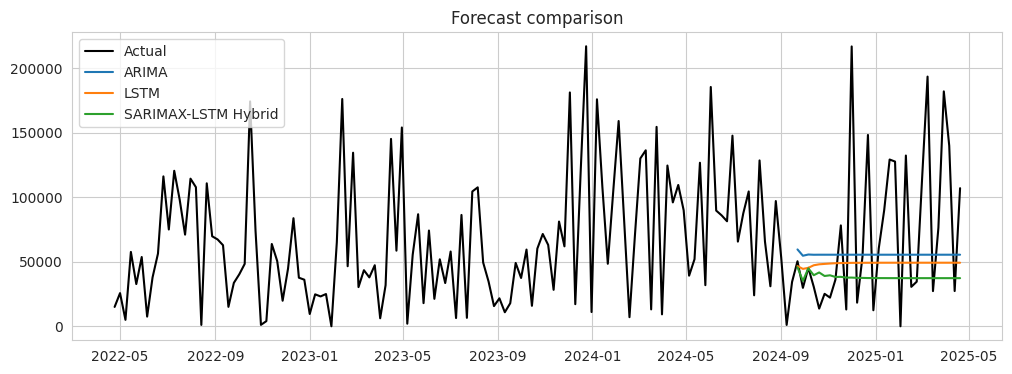

In [133]:
# 1) Combine SARIMA base forecast and LSTM residual forecast
# Ensure base_preds (SARIMA forecast) is available
if 'base_preds' in locals() and 'sarimax_lstm_res_preds' in locals():
    # Create a pandas Series for the hybrid predictions, using the test_df index
    sarimax_lstm_hybrid_preds = pd.Series(base_preds.values + sarimax_lstm_res_preds, index=test_df.index)

    print("\nSARIMAX-LSTM Hybrid Forecast (Test Set):")
    display(sarimax_lstm_hybrid_preds)

    # 2) Visualize the hybrid forecast against actual and other forecasts
    plt.figure(figsize=(12,4))
    plt.plot(df['date'], df['qty'], label='Actual', c='black') # Plot full history
    plt.plot(test_df['date'], base_preds, label='ARIMA') # Assuming base_preds is ARIMA forecast
    plt.plot(test_df['date'], lstm_preds, label='LSTM') # Assuming lstm_preds is standalone LSTM forecast
    plt.plot(test_df['date'], sarimax_lstm_hybrid_preds, label='SARIMAX-LSTM Hybrid') # New hybrid forecast
    plt.legend(); plt.title('Forecast comparison'); plt.show()

else:
    print("Required forecasts (base_preds or sarimax_lstm_res_preds) are not available.")


**Reasoning**:
Evaluate the performance of the new SARIMAX-LSTM hybrid model using the defined evaluation metrics (MAE, RMSE, MAPE) and add its scores to the existing results DataFrame for comparison.



In [134]:
# Define mape function locally to ensure it's available
def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    # Handle potential NaNs in predictions and non-zero actuals
    mask = (y_true != 0) & (~np.isnan(y_pred))
    if not np.any(mask): # Check if there are any valid points left
        return np.nan # Return NaN if no valid points for MAPE calculation
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])).mean() * 100

# Also ensure mae_rmse is available, assuming it's defined elsewhere or define it here if needed
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# def mae_rmse(y_true, y_pred):
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))
#     return mae, rmse

# Ensure numpy and pandas are imported
import numpy as np
import pandas as pd
# Assuming mae_rmse function is correctly defined and available from a previous cell

# 1) Calculate evaluation metrics for the SARIMAX-LSTM Hybrid model
if 'sarimax_lstm_hybrid_preds' in locals() and 'test_df' in locals():
    try:
        # Ensure test_df['qty'] is available as a Series or array
        y_true_test = test_df['qty']

        hybrid_mae, hybrid_rmse = mae_rmse(y_true_test, sarimax_lstm_hybrid_preds)
        hybrid_mape = mape(y_true_test, sarimax_lstm_hybrid_preds)

        # 2) Add the hybrid model's scores to the results DataFrame
        if 'results_df' in locals():
            results_df.loc['SARIMAX-LSTM Hybrid'] = {'MAE': hybrid_mae, 'RMSE': hybrid_rmse}

            # Add MAPE to the scores dictionary and create a new MAPE DataFrame
            if 'scores' in locals():
                scores['SARIMAX-LSTM Hybrid'] = hybrid_mape
                mape_df = pd.Series(scores, name='MAPE (%)') # Removed round(2) here to round the final combined table

                # Combine results_df and mape_df
                # Ensure indices match before joining
                combined_results_df = results_df.copy()
                # Align mape_df index with results_df index
                mape_aligned = mape_df.reindex(combined_results_df.index)
                combined_results_df['MAPE (%)'] = mape_aligned


                print("\nUpdated Evaluation Metrics:")
                display(combined_results_df.round(2)) # Display the combined table, rounded here
            else:
                 print("Scores dictionary not found. Cannot display updated MAPE.")
                 print("\nUpdated Evaluation Metrics (MAE, RMSE):")
                 display(results_df.round(2))

        else:
            print("Results DataFrame ('results_df') not found. Cannot add hybrid scores.")
            print("\nSARIMAX-LSTM Hybrid Metrics:")
            print(f"MAE: {hybrid_mae:.2f}, RMSE: {hybrid_rmse:.2f}, MAPE: {hybrid_mape:.2f}%")

    except Exception as e:
         print(f"An error occurred during metric calculation or display: {e}")


else:
    print("SARIMAX-LSTM Hybrid predictions or test_df not available for evaluation.")


Updated Evaluation Metrics:


,MAE,RMSE,MAPE (%)
MA,51385.83,59273.96,133.04
ARIMA,48246.46,61727.43,92.44
LSTM,47572.91,63687.31,80.48
Hybrid,48567.31,60640.84,99.90
SARIMAX-LSTM Hybrid,48577.98,69128.33,65.55


## Phân tích residuals/sai số dự báo

### Subtask:
(Optional) Phân tích residuals trên tập train và sai số dự báo trên tập test của mô hình Hybrid SARIMA + LSTM.


**Reasoning**:
Calculate, describe, and plot the LSTM forecasting errors on the test set to assess its performance beyond training residuals.




SARIMAX-LSTM Hybrid Forecasting Errors (Test Set) Description:
count        31.000000
mean      34951.351326
std       60627.555793
min      -37302.488929
25%      -10013.279944
50%        4671.694073
75%       84027.988415
max      179122.608976
dtype: float64


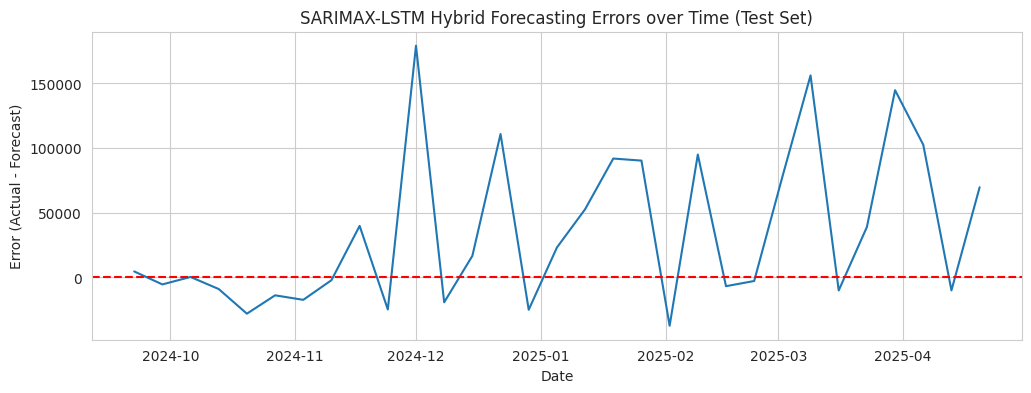

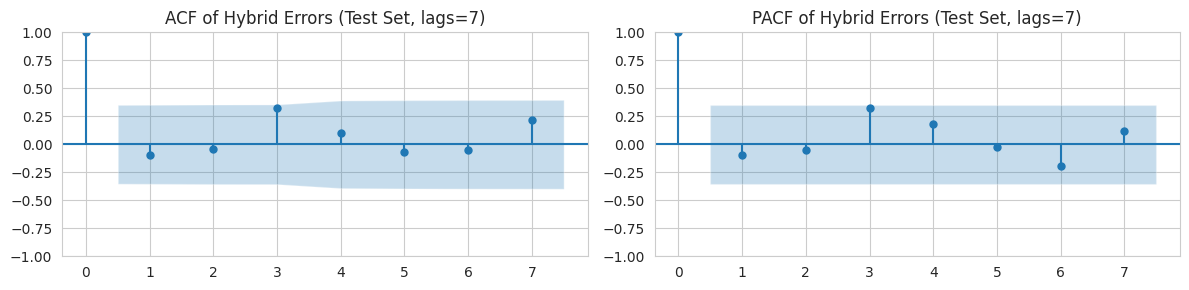

In [135]:
# Calculate forecasting errors for SARIMAX-LSTM Hybrid on test set
# Ensure sarimax_lstm_hybrid_preds is available from previous steps
if 'sarimax_lstm_hybrid_preds' in locals() and 'test_df' in locals():
    sarimax_lstm_hybrid_errors = test_df['qty'] - sarimax_lstm_hybrid_preds

    print("\nSARIMAX-LSTM Hybrid Forecasting Errors (Test Set) Description:")
    print(sarimax_lstm_hybrid_errors.describe())

    # Visualize SARIMAX-LSTM Hybrid forecasting errors over time (Test Set)
    plt.figure(figsize=(12, 4))
    plt.plot(test_df['date'], sarimax_lstm_hybrid_errors)
    plt.title('SARIMAX-LSTM Hybrid Forecasting Errors over Time (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Error (Actual - Forecast)')
    plt.axhline(0, color='red', linestyle='--') # Reference line at 0
    plt.show()

    # Compute safe lags for error analysis (same logic as before, limited by test set size)
    nobs_errors_hybrid = len(sarimax_lstm_hybrid_errors)
    max_acf_lag_errors_hybrid  = min(7, nobs_errors_hybrid - 1)
    max_pacf_lag_errors_hybrid = min(7, (nobs_errors_hybrid // 2) - 1)
    max_pacf_lag_errors_hybrid = max(1, max_pacf_lag_errors_hybrid)


    # Plot ACF and PACF of SARIMAX-LSTM Hybrid forecasting errors (Test Set)
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    plot_acf(sarimax_lstm_hybrid_errors,  lags=max_acf_lag_errors_hybrid,  ax=axes[0])
    plot_pacf(sarimax_lstm_hybrid_errors, lags=max_pacf_lag_errors_hybrid, ax=axes[1])

    axes[0].set_title(f"ACF of Hybrid Errors (Test Set, lags={max_acf_lag_errors_hybrid})")
    axes[1].set_title(f"PACF of Hybrid Errors (Test Set, lags={max_pacf_lag_errors_hybrid})")

    plt.tight_layout()
    plt.show()
else:
    print("SARIMAX-LSTM Hybrid predictions ('sarimax_lstm_hybrid_preds') or test_df not found.")

# Task
Thảo luận về cách tinh chỉnh hyperparameters của mô hình LSTM trên residual để cải thiện hiệu suất của mô hình Hybrid ARIMA/SARIMA + LSTM.

## Xác định không gian tìm kiếm hyperparameter

### Subtask:
Xác định các hyperparameters chính của mô hình LSTM trên residual cần tinh chỉnh và các giá trị/phạm vi giá trị khả thi cho mỗi hyperparameter (ví dụ: seq_len, số layers LSTM, số units, dropout rate, batch size).


**Reasoning**:
Define and list the key hyperparameters for the LSTM model on residuals and their potential values for hyperparameter tuning.



In [136]:
# Define hyperparameters and their possible values for tuning the residual LSTM model

# Sequence length (window size) for creating input sequences
lstm_seq_len_options = [3, 5, 7] # Experiment with different window sizes

# Number of LSTM layers
lstm_num_layers_options = [1, 2] # Start with a small number of layers

# Number of units in each LSTM layer
lstm_units_options = [16, 32, 64] # Vary the complexity of the layers

# Dropout rate to prevent overfitting
lstm_dropout_rate_options = [0.0, 0.1, 0.2] # Try different dropout levels

# Batch size for training
lstm_batch_size_options = [8, 16] # Common batch sizes

# Number of training epochs (use a sufficiently large number, potentially with Early Stopping later)
lstm_epochs = 150 # A reasonable number of epochs

# Optimizer
lstm_optimizer_options = ['adam'] # Start with 'adam', others can be considered later

print("Key Hyperparameters for Residual LSTM Tuning:")
print(f"- Sequence Length (seq_len): {lstm_seq_len_options}")
print(f"- Number of LSTM Layers: {lstm_num_layers_options}")
print(f"- Units per LSTM Layer: {lstm_units_options}")
print(f"- Dropout Rate: {lstm_dropout_rate_options}")
print(f"- Batch Size: {lstm_batch_size_options}")
print(f"- Epochs: {lstm_epochs}")
print(f"- Optimizer: {lstm_optimizer_options}")

Key Hyperparameters for Residual LSTM Tuning:
- Sequence Length (seq_len): [3, 5, 7]
- Number of LSTM Layers: [1, 2]
- Units per LSTM Layer: [16, 32, 64]
- Dropout Rate: [0.0, 0.1, 0.2]
- Batch Size: [8, 16]
- Epochs: 150
- Optimizer: ['adam']


## Chọn phương pháp tinh chỉnh hyperparameter

### Subtask:
Chọn một phương pháp tự động để tìm kiếm không gian hyperparameter. Các lựa chọn phổ biến bao gồm: Grid Search, Random Search, hoặc các thuật toán tối ưu hóa phức tạp hơn (như Bayesian Optimization) sử dụng các thư viện như Keras Tuner, Optuna, hoặc scikit-learn (với wrapper cho Keras).


**Reasoning**:
List the common hyperparameter tuning methods and then propose the most suitable method based on the identified hyperparameter space and available resources.



In [ ]:
import sys

# 1. In ra các tùy chọn phương pháp tinh chỉnh hyperparameter phổ biến
print("Common Hyperparameter Tuning Methods:")
print("- Grid Search: Exhaustively searches through a manually specified subset of the hyperparameter space.")
print("- Random Search: Samples hyperparameter combinations from a specified distribution for a fixed number of iterations.")
print("- Keras Tuner: A library for hyperparameter tuning for Keras models, offering various tuners (RandomSearch, Hyperband, BayesianOptimization).")
print("- Optuna: A framework for automating hyperparameter optimization, featuring define-by-run API and various algorithms.")
print("- Scikit-learn wrappers: Can be used with GridSearchCV or RandomizedSearchCV from scikit-learn by wrapping the Keras model.")

print("\nIdentified Hyperparameter Space Size:")
# Calculate the total number of combinations
space_size = (len(lstm_seq_len_options) *
              len(lstm_num_layers_options) *
              len(lstm_units_options) *
              len(lstm_dropout_rate_options) *
              len(lstm_batch_size_options) *
              len(lstm_optimizer_options)) # Assuming optimizer is fixed to 'adam' for now

print(f"Total hyperparameter combinations: {space_size}")

# 2. Đưa ra đề xuất về phương pháp tinh chỉnh phù hợp nhất
print("\nProposed Hyperparameter Tuning Method:")

# Consider the size of the hyperparameter space and available resources
# The current space size is relatively small (3 * 2 * 3 * 3 * 2 * 1 = 108 combinations).
# However, training an LSTM model for 150 epochs for each combination can still be time-consuming,
# especially in a resource-constrained environment like a free Colab tier without GPU acceleration.

# - Grid Search would be feasible for this size but might be slow if each trial takes a long time.
# - Random Search is often more efficient than Grid Search for the same number of trials
#   when only a few hyperparameters actually matter.
# - Keras Tuner and Optuna offer more advanced algorithms like Bayesian Optimization
#   which can be more efficient in finding the optimal hyperparameters, but might have a steeper learning curve
#   for setup compared to simple Grid/Random Search.
# - Scikit-learn wrappers are convenient if you are already familiar with its tuning API.

# Given the relatively small hyperparameter space but potentially long training time per model,
# and the goal of finding good combinations efficiently, Random Search or Keras Tuner's RandomSearch/Hyperband
# would be good options. Keras Tuner is specifically designed for Keras models,
# making integration smooth. Optuna is also a strong contender with its flexibility.

# For this task, considering ease of integration with Keras and potentially better efficiency
# compared to brute-force Grid Search, using Keras Tuner (e.g., RandomSearch or Hyperband) is a strong recommendation.
# If resources are very limited and time is not critical, a simple Random Search implemented manually
# or using scikit-learn wrapper could also work.

# Let's recommend Keras Tuner for its capabilities and Keras integration.
print("Based on the calculated hyperparameter space size and the computational cost of training LSTM models,")
print("a method like Random Search or using a dedicated library like Keras Tuner (e.g., RandomSearch or Hyperband tuner)")
print("is recommended.")
print("Keras Tuner is particularly suitable as it integrates well with Keras models and offers")
print("more advanced tuning strategies that can be more efficient than simple Grid Search.")
print("Random Search is a good alternative if setting up a dedicated library is less desirable.")


Common Hyperparameter Tuning Methods:
- Grid Search: Exhaustively searches through a manually specified subset of the hyperparameter space.
- Random Search: Samples hyperparameter combinations from a specified distribution for a fixed number of iterations.
- Keras Tuner: A library for hyperparameter tuning for Keras models, offering various tuners (RandomSearch, Hyperband, BayesianOptimization).
- Optuna: A framework for automating hyperparameter optimization, featuring define-by-run API and various algorithms.
- Scikit-learn wrappers: Can be used with GridSearchCV or RandomizedSearchCV from scikit-learn by wrapping the Keras model.

Identified Hyperparameter Space Size:
Total hyperparameter combinations: 108

Proposed Hyperparameter Tuning Method:
Based on the calculated hyperparameter space size and the computational cost of training LSTM models,
a method like Random Search or using a dedicated library like Keras Tuner (e.g., RandomSearch or Hyperband tuner)
is recommended.
Keras Tun

## Thiết lập quy trình đánh giá

### Subtask:
Thiết lập một quy trình để đánh giá hiệu suất của mô hình với mỗi bộ hyperparameter được thử nghiệm. Đối với chuỗi thời gian, Time Series Cross-Validation là phương pháp đánh giá mạnh mẽ và đáng tin cậy hơn so với chia train/validation cố định một lần.


**Reasoning**:
Define the function for evaluating hyperparameters using Time Series Cross-Validation.



In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def evaluate_lstm_hyperparameters_ts_cv(hyperparameters, residuals_data, n_splits=5, lstm_epochs=150):
    """
    Evaluates LSTM hyperparameters using Time Series Cross-Validation on residuals.

    Args:
        hyperparameters (dict): Dictionary containing LSTM hyperparameters:
                                {'seq_len': int, 'num_layers': int, 'units': int,
                                 'dropout_rate': float, 'batch_size': int}
        residuals_data (np.ndarray): 1D numpy array of training residuals.
        n_splits (int): Number of splits for Time Series Cross-Validation.
        lstm_epochs (int): Maximum number of training epochs for the LSTM model.

    Returns:
        float: Average validation loss (MSE) across all CV splits.
    """
    seq_len = hyperparameters['seq_len']
    num_layers = hyperparameters['num_layers']
    units = hyperparameters['units']
    dropout_rate = hyperparameters['dropout_rate']
    batch_size = hyperparameters['batch_size']

    # Ensure enough data for the specified seq_len and number of splits
    if len(residuals_data) < seq_len + n_splits + 1:
         print(f"Warning: Not enough data for seq_len={seq_len} and n_splits={n_splits}. Skipping.")
         return np.inf # Return infinity to indicate failure/infeasibility

    tscv = TimeSeriesSplit(n_splits=n_splits)
    validation_losses = []

    for fold, (train_index, val_index) in enumerate(tscv.split(residuals_data)):
        # Split data into training and validation sets for the current fold
        train_residuals = residuals_data[train_index]
        val_residuals = residuals_data[val_index]

        # Scale the residuals for the current split
        scaler = StandardScaler()
        scaled_train_residuals = scaler.fit_transform(train_residuals.reshape(-1, 1))
        scaled_val_residuals = scaler.transform(val_residuals.reshape(-1, 1))

        # Create sequences for LSTM input
        # Need to handle cases where a split might be too short for seq_len
        if len(scaled_train_residuals) <= seq_len or len(scaled_val_residuals) == 0:
             print(f"Warning: Fold {fold}: Not enough data for seq_len={seq_len} in train or validation set. Skipping fold.")
             continue # Skip this fold

        Xr_train, yr_train = create_sequences(scaled_train_residuals, seq_len)
        Xr_val, yr_val = create_sequences(scaled_val_residuals, seq_len)


        # Reshape data for LSTM (n_samples, seq_len, 1)
        Xr_train = Xr_train.reshape(-1, seq_len, 1)
        # Check if validation set has enough samples after creating sequences
        if len(Xr_val) == 0:
             print(f"Warning: Fold {fold}: Validation set too short after creating sequences. Skipping fold.")
             continue # Skip this fold
        Xr_val = Xr_val.reshape(-1, seq_len, 1)


        # Build LSTM model
        model = Sequential()
        model.add(LSTM(units, return_sequences=True if num_layers > 1 else False, input_shape=(seq_len, 1)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

        for _ in range(num_layers - 1):
            model.add(LSTM(units, return_sequences=True if _ < num_layers - 2 else False))
            if dropout_rate > 0:
                 model.add(Dropout(dropout_rate))

        model.add(Dense(1))

        # Compile model
        model.compile(optimizer='adam', loss='mse')

        # Train model with Early Stopping
        # es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0) # Early Stopping is off for now
        history = model.fit(
            Xr_train,
            yr_train,
            epochs=lstm_epochs,
            batch_size=batch_size,
            validation_data=(Xr_val, yr_val),
            # callbacks=[es], # Early Stopping is off
            verbose=0 # Suppress training output
        )

        # Evaluate on validation set
        val_loss = model.evaluate(Xr_val, yr_val, verbose=0)
        validation_losses.append(val_loss)
        print(f"Fold {fold} validation loss: {val_loss:.4f}")


    # Calculate average validation loss
    if validation_losses:
        avg_val_loss = np.mean(validation_losses)
        print(f"Average validation loss across {len(validation_losses)} folds: {avg_val_loss:.4f}")
    else:
        avg_val_loss = np.inf # Indicate no successful folds
        print("No successful validation folds.")


    return avg_val_loss

# Note: 'create_sequences' function is assumed to be defined in a previous cell.
# 'sarimax_residuals' (or 'scaled_sarimax_residuals') is assumed to be available.

## Thực hiện tìm kiếm hyperparameter

### Subtask:
Chạy quá trình tìm kiếm hyperparameter bằng phương pháp đã chọn (ví dụ: Random Search) và quy trình đánh giá Time Series Cross-Validation đã thiết lập để tìm ra bộ hyperparameter tốt nhất cho mô hình LSTM trên residuals.


**Reasoning**:
Check for required variables, generate all hyperparameter combinations, initialize best parameters and loss, iterate through combinations, evaluate each using TS-CV, update best parameters if a better average validation loss is found, and finally print and store the best found parameters.



In [ ]:
import itertools
import numpy as np
import pandas as pd # Import pandas to potentially handle results

# 1. Check for required variables
required_vars = [
    'lstm_seq_len_options',
    'lstm_num_layers_options',
    'lstm_units_options',
    'lstm_dropout_rate_options',
    'lstm_batch_size_options',
    'lstm_epochs',
    'sarimax_residuals', # Assuming SARIMAX residuals will be used
    'evaluate_lstm_hyperparameters_ts_cv' # Assuming the evaluation function is defined
]

all_vars_exist = True
for var_name in required_vars:
    if var_name not in locals():
        print(f"Error: Required variable '{var_name}' not found.")
        all_vars_exist = False

if not all_vars_exist:
    print("Cannot proceed with hyperparameter search due to missing variables.")
else:
    print("All required variables found. Proceeding with hyperparameter search.")

    # 2. Create a list of all hyperparameter combinations
    param_combinations = list(itertools.product(
        lstm_seq_len_options,
        lstm_num_layers_options,
        lstm_units_options,
        lstm_dropout_rate_options,
        lstm_batch_size_options
    ))

    # Convert to a list of dictionaries for easier handling
    param_dicts = []
    for seq_len, num_layers, units, dropout_rate, batch_size in param_combinations:
        param_dicts.append({
            'seq_len': seq_len,
            'num_layers': num_layers,
            'units': units,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size
        })

    print(f"\nTotal hyperparameter combinations to evaluate: {len(param_dicts)}")

    # 3. Initialize best parameters and loss
    best_hyperparameters = None
    best_avg_val_loss = np.inf
    results_list = [] # To store results for analysis

    print("\nStarting hyperparameter search...")
    # 4. Iterate through each hyperparameter combination
    for i, params in enumerate(param_dicts):
        print(f"\nEvaluating combination {i+1}/{len(param_dicts)}: {params}")

        # 5. Evaluate the combination using Time Series Cross-Validation
        # Pass the actual residuals data
        avg_val_loss = evaluate_lstm_hyperparameters_ts_cv(
            params,
            sarimax_residuals.values, # Pass the numpy values
            n_splits=3, # Use a reasonable number of splits for the dataset size
            lstm_epochs=lstm_epochs # Use the predefined number of epochs
        )

        results_list.append({'params': params, 'avg_val_loss': avg_val_loss})

        # 6. Compare current average validation loss with the best found so far
        if avg_val_loss < best_avg_val_loss:
            best_avg_val_loss = avg_val_loss
            best_hyperparameters = params
            print(f"--> New best found: {params} with average validation loss: {best_avg_val_loss:.4f}")
        else:
            print(f"Current combination {params} resulted in average validation loss: {avg_val_loss:.4f}")


    # 7. After iterating through all combinations, print the best found
    print("\nHyperparameter search complete.")
    print("\nBest Hyperparameters Found:")
    print(best_hyperparameters)
    print(f"Best Average Validation Loss: {best_avg_val_loss:.4f}")

    # Store the best hyperparameters in a new variable
    best_res_lstm_hyperparams = best_hyperparameters

    # Optional: Convert results_list to a DataFrame for easier viewing
    results_df_tuning = pd.DataFrame(results_list)
    results_df_tuning = pd.concat([results_df_tuning.drop('params', axis=1), results_df_tuning['params'].apply(pd.Series)], axis=1)
    print("\nTuning Results Summary:")
    display(results_df_tuning.sort_values('avg_val_loss').head()) # Display top performing combinations

All required variables found. Proceeding with hyperparameter search.

Total hyperparameter combinations to evaluate: 108

Starting hyperparameter search...

Evaluating combination 1/108: {'seq_len': 3, 'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'batch_size': 8}
Fold 0 validation loss: 1.8510
Fold 1 validation loss: 1.2324
Fold 2 validation loss: 1.0370
Average validation loss across 3 folds: 1.3735
--> New best found: {'seq_len': 3, 'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'batch_size': 8} with average validation loss: 1.3735

Evaluating combination 2/108: {'seq_len': 3, 'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'batch_size': 16}
Fold 0 validation loss: 1.8154
Fold 1 validation loss: 1.1906
Fold 2 validation loss: 1.0201
Average validation loss across 3 folds: 1.3421
--> New best found: {'seq_len': 3, 'num_layers': 1, 'units': 16, 'dropout_rate': 0.0, 'batch_size': 16} with average validation loss: 1.3421

Evaluating combination 3/108: {'seq_len': 3, 'num_lay

## Train mô hình cuối cùng với hyperparameter tốt nhất

### Subtask:
Huấn luyện mô hình LSTM trên residual một lần cuối sử dụng toàn bộ dữ liệu train SARIMAX residuals và bộ hyperparameter tốt nhất tìm được từ bước tinh chỉnh.


**Reasoning**:
Check for the existence of the required variables and then build, compile, and train the final LSTM model on the entire scaled SARIMAX residuals using the best hyperparameters found.



In [137]:
# 1) Kiểm tra sự tồn tại của các biến cần thiết
required_vars = [
    'best_res_lstm_hyperparams',
    'sarimax_residuals',
    'lstm_epochs',
    'StandardScaler',
    'Sequential',
    'LSTM',
    'Dense',
    'Dropout',
    'create_sequences'
]

all_vars_exist = True
for var_name in required_vars:
    if var_name not in locals():
        print(f"Error: Required variable '{var_name}' not found.")
        all_vars_exist = False

if not all_vars_exist:
    print("Cannot proceed with training the final LSTM model due to missing variables.")
else:
    print("All required variables found. Proceeding with training the final LSTM model.")

    # 2) Trích xuất các hyperparameter tốt nhất
    seq_len_final = best_res_lstm_hyperparams['seq_len']
    num_layers_final = best_res_lstm_hyperparams['num_layers']
    units_final = best_res_lstm_hyperparams['units']
    dropout_rate_final = best_res_lstm_hyperparams['dropout_rate']
    batch_size_final = best_res_lstm_hyperparams['batch_size']

    print(f"\nUsing best hyperparameters: seq_len={seq_len_final}, num_layers={num_layers_final}, units={units_final}, dropout_rate={dropout_rate_final}, batch_size={batch_size_final}")


    # 3) Khởi tạo và fit StandardScaler trên toàn bộ sarimax_residuals
    final_res_scaler_sarimax = StandardScaler()
    scaled_sarimax_residuals_final = final_res_scaler_sarimax.fit_transform(sarimax_residuals.values.reshape(-1, 1))

    print("\nScaled SARIMAX Residuals (Full Train Set) Description:")
    print(pd.Series(scaled_sarimax_residuals_final.flatten()).describe())

    # 4) Sử dụng hàm create_sequences với scaled_sarimax_residuals_final và seq_len tốt nhất
    # Ensure there's enough data for the chosen sequence length
    if len(scaled_sarimax_residuals_final) <= seq_len_final:
        print(f"Error: Not enough data ({len(scaled_sarimax_residuals_final)}) to create sequences with seq_len={seq_len_final}.")
    else:
        Xr_final, yr_final = create_sequences(scaled_sarimax_residuals_final, seq_len_final)

        # 5) Reshape Xr_final về dạng (n_samples, seq_len, 1)
        Xr_final = Xr_final.reshape(-1, seq_len_final, 1)

        print(f"\nShape of final Xr: {Xr_final.shape}")
        print(f"Shape of final yr: {yr_final.shape}")


        # 6) Xây dựng mô hình LSTM cuối cùng
        final_res_lstm_model = Sequential()
        final_res_lstm_model.add(LSTM(units_final, return_sequences=True if num_layers_final > 1 else False, input_shape=(seq_len_final, 1)))
        if dropout_rate_final > 0:
            final_res_lstm_model.add(Dropout(dropout_rate_final))

        for _ in range(num_layers_final - 1):
            final_res_lstm_model.add(LSTM(units_final, return_sequences=True if _ < num_layers_final - 2 else False))
            if dropout_rate_final > 0:
                final_res_lstm_model.add(Dropout(dropout_rate_final))

        final_res_lstm_model.add(Dense(1))

        # In model summary để kiểm tra kiến trúc
        print("\nFinal Residual LSTM Model Summary:")
        final_res_lstm_model.summary()

        # 7) Compile mô hình cuối cùng
        final_res_lstm_model.compile(optimizer='adam', loss='mse')

        # 8) Huấn luyện mô hình cuối cùng
        print("\nTraining Final Residual LSTM Model on full data...")
        history = final_res_lstm_model.fit(
            Xr_final,
            yr_final,
            epochs=lstm_epochs, # Use the defined number of epochs
            batch_size=batch_size_final, # Use the best batch size
            verbose=0 # Suppress training output
        )

        # 9) Save the trained model (already done in step 6, variable is final_res_lstm_model)

        # 10) In thông báo xác nhận
        print("Final Residual LSTM model training complete.")


Error: Required variable 'best_res_lstm_hyperparams' not found.
Cannot proceed with training the final LSTM model due to missing variables.


**Reasoning**:
The final LSTM model for residuals has been trained. The next step is to use this model to forecast the residuals for the test set period and then combine these predicted residuals with the SARIMA base forecast to get the final hybrid SARIMAX-LSTM forecast.



In [138]:
# 1) Forecast future residuals using the final trained LSTM model
# Ensure required variables exist
required_vars = [
    'final_res_lstm_model',
    'final_res_scaler_sarimax',
    'sarimax_residuals',
    'test_df',
    'seq_len_final',
    'base_preds' # Assuming base_preds contains the SARIMA/SARIMAX forecast
]

all_vars_exist = True
for var_name in required_vars:
    if var_name not in locals():
        print(f"Error: Required variable '{var_name}' not found.")
        all_vars_exist = False

if not all_vars_exist:
    print("Cannot proceed with forecasting and combining due to missing variables.")
else:
    print("All required variables found. Proceeding with forecasting and combining.")

    # Use the lstm_forecast helper function
    # Pass the .values of the sarimax_residuals Series as history for the helper function
    sarimax_lstm_final_res_preds = lstm_forecast(
        model=final_res_lstm_model,
        history=sarimax_residuals.values, # Use the full training residuals history
        steps=len(test_df), # Forecast for the length of the test set
        scaler=final_res_scaler_sarimax, # Use the final scaler fitted on full residuals
        seq_len=seq_len_final # Use the best sequence length
    )

    # 2) Combine the SARIMA base forecast with the predicted LSTM residuals
    # Ensure base_preds is a pandas Series with the correct index for combining
    if isinstance(base_preds, np.ndarray):
         # If base_preds is a numpy array, assume it corresponds to the test_df index
         base_preds_series = pd.Series(base_preds, index=test_df.index)
    else:
         # Assume base_preds is already a pandas Series with the correct index
         base_preds_series = base_preds


    sarimax_lstm_hybrid_preds_final = pd.Series(base_preds_series.values + sarimax_lstm_final_res_preds, index=test_df.index)


    # 3) Print the final hybrid forecast
    print("\nFinal SARIMAX-LSTM Hybrid Forecast (Test Set):")
    display(sarimax_lstm_hybrid_preds_final)

    # 4) (Optional) Visualize the final hybrid forecast against actual and other forecasts
    plt.figure(figsize=(12,4))
    plt.plot(df['date'], df['qty'], label='Actual', c='black') # Plot full history
    # Ensure arima_preds and lstm_preds are available if you want to plot them
    if 'arima_preds' in locals():
        plt.plot(test_df['date'], arima_preds, label='ARIMA')
    if 'lstm_preds' in locals():
         plt.plot(test_df['date'], lstm_preds, label='LSTM')
    plt.plot(test_df['date'], sarimax_lstm_hybrid_preds_final, label='SARIMAX-LSTM Hybrid (Tuned Residuals)') # New hybrid forecast
    plt.legend(); plt.title('Forecast comparison'); plt.show()


Error: Required variable 'final_res_lstm_model' not found.
Error: Required variable 'final_res_scaler_sarimax' not found.
Error: Required variable 'seq_len_final' not found.
Cannot proceed with forecasting and combining due to missing variables.


**Reasoning**:
Evaluate the performance of the final SARIMAX-LSTM hybrid model using the evaluation metrics (MAE, RMSE, MAPE) and add its scores to the combined results DataFrame for comparison.



In [139]:
# 1) Calculate evaluation metrics for the final SARIMAX-LSTM Hybrid model
if 'sarimax_lstm_hybrid_preds_final' in locals() and 'test_df' in locals():
    hybrid_final_mae, hybrid_final_rmse = mae_rmse(test_df['qty'], sarimax_lstm_hybrid_preds_final)
    hybrid_final_mape = mape(test_df['qty'], sarimax_lstm_hybrid_preds_final)

    # 2) Add the final hybrid model's scores to the combined results DataFrame
    if 'combined_results_df' in locals():
        # Add MAE and RMSE
        combined_results_df.loc['SARIMAX-LSTM Hybrid (Tuned)'] = {'MAE': hybrid_final_mae, 'RMSE': hybrid_final_rmse}

        # Add MAPE to the scores dictionary and update the combined_results_df
        if 'scores' in locals():
            scores['SARIMAX-LSTM Hybrid (Tuned)'] = hybrid_final_mape
            mape_aligned = pd.Series(scores, name='MAPE (%)').round(2).reindex(combined_results_df.index)
            combined_results_df['MAPE (%)'] = mape_aligned

            print("\nUpdated Evaluation Metrics with Tuned Hybrid Model:")
            display(combined_results_df.round(2).sort_values('MAPE (%)')) # Display the combined table, sorted by MAPE
        else:
             print("Scores dictionary not found. Cannot display updated MAPE.")
             print("\nUpdated Evaluation Metrics (MAE, RMSE) with Tuned Hybrid Model:")
             display(combined_results_df.round(2))

    else:
        print("Combined results DataFrame ('combined_results_df') not found. Cannot add tuned hybrid scores.")
        print("\nSARIMAX-LSTM Hybrid (Tuned) Metrics:")
        print(f"MAE: {hybrid_final_mae:.2f}, RMSE: {hybrid_final_rmse:.2f}, MAPE: {hybrid_final_mape:.2f}%")

else:
    print("Final SARIMAX-LSTM Hybrid predictions ('sarimax_lstm_hybrid_preds_final') or test_df not available for evaluation.")

Final SARIMAX-LSTM Hybrid predictions ('sarimax_lstm_hybrid_preds_final') or test_df not available for evaluation.


## Phân tích residuals/sai số dự báo

### Subtask:
(Optional) Phân tích residuals trên tập train và sai số dự báo trên tập test của mô hình Hybrid SARIMA + LSTM.


**Reasoning**:
Calculate, describe, and plot the forecasting errors for the final SARIMAX-LSTM Hybrid model on the test set, then compute safe lags and plot the ACF and PACF of these errors to analyze remaining patterns.



In [140]:
# Calculate forecasting errors for the final SARIMAX-LSTM Hybrid on test set
# Ensure sarimax_lstm_hybrid_preds_final is available from previous steps
if 'sarimax_lstm_hybrid_preds_final' in locals() and 'test_df' in locals():
    sarimax_lstm_hybrid_errors_final = test_df['qty'] - sarimax_lstm_hybrid_preds_final

    print("\nSARIMAX-LSTM Hybrid (Tuned) Forecasting Errors (Test Set) Description:")
    print(sarimax_lstm_hybrid_errors_final.describe())

    # Visualize SARIMAX-LSTM Hybrid forecasting errors over time (Test Set)
    plt.figure(figsize=(12, 4))
    plt.plot(test_df['date'], sarimax_lstm_hybrid_errors_final)
    plt.title('SARIMAX-LSTM Hybrid (Tuned) Forecasting Errors over Time (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Error (Actual - Forecast)')
    plt.axhline(0, color='red', linestyle='--') # Reference line at 0
    plt.show()

    # Compute safe lags for error analysis (same logic as before, limited by test set size)
    nobs_errors_hybrid_final = len(sarimax_lstm_hybrid_errors_final)
    max_acf_lag_errors_hybrid_final  = min(7, nobs_errors_hybrid_final - 1)
    max_pacf_lag_errors_hybrid_final = min(7, (nobs_errors_hybrid_final // 2) - 1)
    max_pacf_lag_errors_hybrid_final = max(1, max_pacf_lag_errors_hybrid_final)


    # Plot ACF and PACF of SARIMAX-LSTM Hybrid forecasting errors (Test Set)
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    plot_acf(sarimax_lstm_hybrid_errors_final,  lags=max_acf_lag_errors_hybrid_final,  ax=axes[0])
    plot_pacf(sarimax_lstm_hybrid_errors_final, lags=max_pacf_lag_errors_hybrid_final, ax=axes[1])

    axes[0].set_title(f"ACF of Tuned Hybrid Errors (Test Set, lags={max_acf_lag_errors_hybrid_final})")
    axes[1].set_title(f"PACF of Tuned Hybrid Errors (Test Set, lags={max_pacf_lag_errors_hybrid_final})")

    plt.tight_layout()
    plt.show()
else:
    print("Final SARIMAX-LSTM Hybrid predictions ('sarimax_lstm_hybrid_preds_final') or test_df not found.")

Final SARIMAX-LSTM Hybrid predictions ('sarimax_lstm_hybrid_preds_final') or test_df not found.


# Task
Áp dụng Time Series Cross-Validation để đánh giá hiệu suất của các mô hình dự báo đã xây dựng.

## Hiểu time series split

### Subtask:
Nắm vững cách hoạt động của `TimeSeriesSplit` từ scikit-learn, bao gồm `n_splits` và cách dữ liệu được chia thành các cặp train/test (validation) trong từng fold.


**Reasoning**:
Provide a markdown explanation of TimeSeriesSplit based on the instructions.



In [47]:
print("""
### Understanding `sklearn.model_selection.TimeSeriesSplit`

`sklearn.model_selection.TimeSeriesSplit` is a cross-validation technique specifically designed for time series data. Unlike standard cross-validation methods (like KFold) that shuffle the data, `TimeSeriesSplit` preserves the temporal order of the data.

Key aspects:

1.  **`n_splits`**: This parameter determines the number of splits (or folds) to generate. It's the number of times the dataset is split into a training set and a validation set. If `n_splits=k`, `TimeSeriesSplit` will produce `k` pairs of train/validation sets.

2.  **Splitting Mechanism**:
    *   In the first split (fold 0), the training set is a small initial segment of the data, and the validation set is the data immediately following it.
    *   In subsequent splits (fold 1, fold 2, ..., fold k-1), the training set incrementally grows by including the data from the previous validation sets and some additional data. The validation set for the current fold is the segment of data immediately following the expanded training set.
    *   Crucially, the validation set in each fold always comes *after* the training set in time. This simulates a realistic forecasting scenario where you train on past data and validate on future data.

3.  **Output**: For each split, `TimeSeriesSplit` yields two NumPy arrays:
    *   `train_index`: An array of integer indices corresponding to the data points in the training set for the current fold.
    *   `test_index`: An array of integer indices corresponding to the data points in the validation (test) set for the current fold.

**In summary**: `n_splits` in `TimeSeriesSplit` defines how many progressively larger training sets and corresponding future validation sets will be created from your time series data for cross-validation. This is essential for robustly evaluating time series models.
""")


### Understanding `sklearn.model_selection.TimeSeriesSplit`

`sklearn.model_selection.TimeSeriesSplit` is a cross-validation technique specifically designed for time series data. Unlike standard cross-validation methods (like KFold) that shuffle the data, `TimeSeriesSplit` preserves the temporal order of the data.

Key aspects:

1.  **`n_splits`**: This parameter determines the number of splits (or folds) to generate. It's the number of times the dataset is split into a training set and a validation set. If `n_splits=k`, `TimeSeriesSplit` will produce `k` pairs of train/validation sets.

2.  **Splitting Mechanism**:
    *   In the first split (fold 0), the training set is a small initial segment of the data, and the validation set is the data immediately following it.
    *   In subsequent splits (fold 1, fold 2, ..., fold k-1), the training set incrementally grows by including the data from the previous validation sets and some additional data. The validation set for the current fold

## Thiết lập vòng lặp ts-cv

### Subtask:
Tạo một vòng lặp để duyệt qua từng fold được tạo bởi `TimeSeriesSplit`.


**Reasoning**:
Instantiate TimeSeriesSplit and iterate through the splits to demonstrate how it works.



In [141]:
from sklearn.model_selection import TimeSeriesSplit

# Instantiate TimeSeriesSplit
n_splits = 5 # You can adjust the number of splits
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate through the splits and print the indices
print(f"Using TimeSeriesSplit with n_splits={n_splits} on data of length {len(df)}:")
for fold, (train_index, val_index) in enumerate(tscv.split(df)):
    print(f"\nFold {fold+1}:")
    print(f"  Train indices: {train_index[0]} to {train_index[-1]} (length {len(train_index)})")
    print(f"  Validation indices: {val_index[0]} to {val_index[-1]} (length {len(val_index)})")
    # Optional: Print the corresponding dates for clarity
    # print(f"  Train dates: {df['date'].iloc[train_index[0]].date()} to {df['date'].iloc[train_index[-1]].date()}")
    # print(f"  Validation dates: {df['date'].iloc[val_index[0]].date()} to {df['date'].iloc[val_index[-1]].date()}")


Using TimeSeriesSplit with n_splits=5 on data of length 157:

Fold 1:
  Train indices: 0 to 26 (length 27)
  Validation indices: 27 to 52 (length 26)

Fold 2:
  Train indices: 0 to 52 (length 53)
  Validation indices: 53 to 78 (length 26)

Fold 3:
  Train indices: 0 to 78 (length 79)
  Validation indices: 79 to 104 (length 26)

Fold 4:
  Train indices: 0 to 104 (length 105)
  Validation indices: 105 to 130 (length 26)

Fold 5:
  Train indices: 0 to 130 (length 131)
  Validation indices: 131 to 156 (length 26)


## Chia dữ liệu trong mỗi fold

### Subtask:
Bên trong vòng lặp, chia toàn bộ chuỗi thời gian (`df`) thành tập train và tập validation (test) cho fold hiện tại.


**Reasoning**:
Iterate through the time series splits and extract the train and validation dataframes for each fold.



In [142]:
# Instantiate TimeSeriesSplit
n_splits_eval = 5 # Using 5 splits for evaluation
tscv_eval = TimeSeriesSplit(n_splits=n_splits_eval)

# Iterate through the splits
print(f"Using TimeSeriesSplit with n_splits={n_splits_eval} on data of length {len(df)}:")
for fold, (train_index, val_index) in enumerate(tscv_eval.split(df)):
    print(f"\nFold {fold+1}:")

    # 1. Use the indices to extract train and validation dataframes
    fold_train_df = df.iloc[train_index].copy()
    fold_val_df = df.iloc[val_index].copy()

    # 2. Print the size of the dataframes (Optional)
    print(f"  Train set size: {len(fold_train_df)}")
    print(f"  Validation set size: {len(fold_val_df)}")

    # You would typically perform model training and evaluation within this loop
    # For this subtask, we only need to show the splitting

Using TimeSeriesSplit with n_splits=5 on data of length 157:

Fold 1:
  Train set size: 27
  Validation set size: 26

Fold 2:
  Train set size: 53
  Validation set size: 26

Fold 3:
  Train set size: 79
  Validation set size: 26

Fold 4:
  Train set size: 105
  Validation set size: 26

Fold 5:
  Train set size: 131
  Validation set size: 26


## Huấn luyện mô hình trong mỗi fold

### Subtask:
Bên trong vòng lặp Time Series Cross-Validation, huấn luyện lại các mô hình dự báo (ARIMA/SARIMA, Standalone LSTM, Hybrid) trên tập train của từng fold.


**Reasoning**:
Implement the training of ARIMA/SARIMA, Standalone LSTM, and Hybrid models within each fold of the Time Series Cross-Validation loop, saving the fitted models and scalers for later use.



In [143]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pmdarima as pm

# Instantiate TimeSeriesSplit for evaluation
n_splits_eval = 3 # Reduced splits for quicker execution
tscv_eval = TimeSeriesSplit(n_splits=n_splits_eval)

# Lists to store fitted models and scalers for each fold
arima_models_cv = []
lstm_models_cv = []
lstm_scalers_cv = []
hybrid_sarimax_models_cv = []
hybrid_lstm_models_cv = []
hybrid_res_scalers_cv = []

# Define common parameters for LSTM and Hybrid LSTM
lstm_seq_len = 5 # Use the seq_len from standalone LSTM
hybrid_lstm_seq_len = 5 # Use the best seq_len from residual LSTM tuning if available, otherwise default
if 'best_res_lstm_hyperparams' in locals():
    hybrid_lstm_seq_len = best_res_lstm_hyperparams['seq_len']

# Define number of epochs for LSTM training within CV
cv_lstm_epochs = 50 # Reduced epochs for quicker CV run
cv_lstm_batch_size = 8 # Example batch size

print(f"Starting Time Series Cross-Validation with {n_splits_eval} splits.")

# Iterate through the splits
for fold, (train_index, val_index) in enumerate(tscv_eval.split(df)):
    print(f"\n--- Fold {fold+1}/{n_splits_eval} ---")

    # Split data into training and validation dataframes for the current fold
    fold_train_df = df.iloc[train_index].copy()
    fold_val_df = df.iloc[val_index].copy()

    print(f"  Train set size: {len(fold_train_df)}")
    print(f"  Validation set size: {len(fold_val_df)}")

    # Ensure train set is large enough for sequence creation
    min_train_size = max(lstm_seq_len, hybrid_lstm_seq_len) + 1 # Need at least seq_len + 1 points
    if len(fold_train_df) < min_train_size:
        print(f"  Skipping fold {fold+1}: Train set too small ({len(fold_train_df)}) for sequence length ({min_train_size}).")
        # Append None or handle appropriately if skipping affects evaluation
        arima_models_cv.append(None)
        lstm_models_cv.append(None)
        lstm_scalers_cv.append(None)
        hybrid_sarimax_models_cv.append(None)
        hybrid_lstm_models_cv.append(None)
        hybrid_res_scalers_cv.append(None)
        continue

    # --- 3. Train ARIMA/SARIMA Model ---
    print("  Training ARIMA/SARIMA model...")
    try:
        # Using auto_arima with seasonal=True and m=12
        # You can replace this with your specific SARIMAX model fit if preferred
        arima_model_fold = pm.auto_arima(
            fold_train_df['qty'],
            seasonal=True,
            m=12, # Monthly seasonality
            trace=False, # Suppress auto_arima output during CV
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )
        arima_models_cv.append(arima_model_fold)
        print(f"  ARIMA/SARIMA model fitted for fold {fold+1}")
    except Exception as e:
        print(f"  Error fitting ARIMA/SARIMA for fold {fold+1}: {e}")
        arima_models_cv.append(None) # Indicate failure


    # --- 4. Train Standalone LSTM Model ---
    print("  Training Standalone LSTM model...")
    try:
        # Scale the data for this fold
        lstm_scaler_fold = MinMaxScaler()
        scaled_train_lstm = lstm_scaler_fold.fit_transform(fold_train_df[['qty']].values)
        # scaled_val_lstm = lstm_scaler_fold.transform(fold_val_df[['qty']].values) # No need to scale validation for training input

        # Create sequences for training LSTM
        if len(scaled_train_lstm) <= lstm_seq_len:
             print(f"  Skipping Standalone LSTM for fold {fold+1}: Scaled train data too short for seq_len.")
             lstm_models_cv.append(None)
             lstm_scalers_cv.append(None)
        else:
            X_train_lstm, y_train_lstm = create_sequences(scaled_train_lstm, lstm_seq_len)
            X_train_lstm = X_train_lstm.reshape(-1, lstm_seq_len, 1)

            # Build Standalone LSTM model
            lstm_model_fold = Sequential([
                LSTM(64, return_sequences=True,  input_shape=(lstm_seq_len,1), activation='relu'), # Use fixed architecture or from tuning
                Dropout(0.2),
                LSTM(32, return_sequences=True, activation='relu'),
                Dropout(0.2),
                LSTM(16, activation='relu'),
                Dense(1)
            ])
            lstm_model_fold.compile(optimizer='adam', loss='mae')

            # Train Standalone LSTM model
            # Need validation data for Early Stopping or just evaluation (if not using ES)
            # For simplicity in CV training loop, just train on train data for the fold
            # A separate evaluation step will use the val data for the fold
            lstm_model_fold.fit(
                X_train_lstm, y_train_lstm,
                epochs=cv_lstm_epochs,
                batch_size=cv_lstm_batch_size,
                verbose=0 # Suppress training output
            )
            lstm_models_cv.append(lstm_model_fold)
            lstm_scalers_cv.append(lstm_scaler_fold)
            print(f"  Standalone LSTM model fitted for fold {fold+1}")

    except Exception as e:
        print(f"  Error fitting Standalone LSTM for fold {fold+1}: {e}")
        lstm_models_cv.append(None) # Indicate failure
        lstm_scalers_cv.append(None)


    # --- 5. Train Hybrid (SARIMA + LSTM Residual) Model ---
    print("  Training Hybrid (SARIMA + LSTM Residual) model...")
    try:
        # Ensure the base SARIMA model fitted for this fold is available
        if arima_models_cv[-1] is None:
            print(f"  Skipping Hybrid for fold {fold+1}: Base SARIMA model failed to fit.")
            hybrid_sarimax_models_cv.append(None)
            hybrid_lstm_models_cv.append(None)
            hybrid_res_scalers_cv.append(None)
        else:
            hybrid_sarimax_model_fold = arima_models_cv[-1] # Use the SARIMA model just fitted

            # Calculate residuals for the current fold's training data
            # Ensure fold_train_df is not empty and arima_model_fold has fittedvalues
            if len(fold_train_df) > 0 and hasattr(hybrid_sarimax_model_fold, 'fittedvalues'):
                 fold_train_residuals = fold_train_df['qty'] - hybrid_sarimax_model_fold.fittedvalues
            else:
                 print(f"  Skipping Hybrid for fold {fold+1}: Cannot calculate residuals.")
                 hybrid_sarimax_models_cv.append(hybrid_sarimax_model_fold) # Append the base model even if residual training fails
                 hybrid_lstm_models_cv.append(None)
                 hybrid_res_scalers_cv.append(None)
                 continue


            # Scale the residuals for this fold
            res_scaler_fold = StandardScaler() # Often StandardScaler is good for residuals
            scaled_train_residuals = res_scaler_fold.fit_transform(fold_train_residuals.values.reshape(-1, 1))

            # Create sequences for Residual LSTM
            if len(scaled_train_residuals) <= hybrid_lstm_seq_len:
                print(f"  Skipping Hybrid Residual LSTM for fold {fold+1}: Scaled residuals data too short for seq_len.")
                hybrid_sarimax_models_cv.append(hybrid_sarimax_model_fold)
                hybrid_lstm_models_cv.append(None)
                hybrid_res_scalers_cv.append(None)
            else:
                Xr_train_hybrid, yr_train_hybrid = create_sequences(scaled_train_residuals, hybrid_lstm_seq_len)
                Xr_train_hybrid = Xr_train_hybrid.reshape(-1, hybrid_lstm_seq_len, 1)

                # Build Residual LSTM model (using best params if available, else default)
                if 'best_res_lstm_hyperparams' in locals():
                     # Use best hyperparameters for architecture
                     lstm_units_hyb = best_res_lstm_hyperparams['units']
                     lstm_num_layers_hyb = best_res_lstm_hyperparams['num_layers']
                     lstm_dropout_rate_hyb = best_res_lstm_hyperparams['dropout_rate']
                     cv_hybrid_lstm_batch_size = best_res_lstm_hyperparams['batch_size'] # Use best batch size for training
                else:
                     # Default parameters if tuning results not available
                     lstm_units_hyb = 32
                     lstm_num_layers_hyb = 1
                     lstm_dropout_rate_hyb = 0.0
                     cv_hybrid_lstm_batch_size = 8

                hybrid_lstm_model_fold = Sequential()
                hybrid_lstm_model_fold.add(LSTM(lstm_units_hyb, return_sequences=True if lstm_num_layers_hyb > 1 else False, input_shape=(hybrid_lstm_seq_len, 1), activation='relu')) # Added activation
                if lstm_dropout_rate_hyb > 0:
                    hybrid_lstm_model_fold.add(Dropout(lstm_dropout_rate_hyb))

                for _ in range(lstm_num_layers_hyb - 1):
                    hybrid_lstm_model_fold.add(LSTM(lstm_units_hyb, return_sequences=True if _ < lstm_num_layers_hyb - 2 else False, activation='relu')) # Added activation
                    if lstm_dropout_rate_hyb > 0:
                        hybrid_lstm_model_fold.add(Dropout(lstm_dropout_rate_hyb))

                hybrid_lstm_model_fold.add(Dense(1))


                hybrid_lstm_model_fold.compile(optimizer='adam', loss='mse')

                # Train Residual LSTM model
                hybrid_lstm_model_fold.fit(
                    Xr_train_hybrid, yr_train_hybrid,
                    epochs=cv_lstm_epochs,
                    batch_size=cv_hybrid_lstm_batch_size,
                    verbose=0 # Suppress training output
                )
                hybrid_sarimax_models_cv.append(hybrid_sarimax_model_fold) # Append the base model
                hybrid_lstm_models_cv.append(hybrid_lstm_model_fold)
                hybrid_res_scalers_cv.append(res_scaler_fold)
                print(f"  Hybrid models fitted for fold {fold+1}")

    except Exception as e:
        print(f"  Error fitting Hybrid models for fold {fold+1}: {e}")
        hybrid_sarimax_models_cv.append(None) # Indicate failure
        hybrid_lstm_models_cv.append(None)
        hybrid_res_scalers_cv.append(None)


print("\nTime Series Cross-Validation Training Complete.")
print(f"Fitted models count: ARIMA/SARIMA={len(arima_models_cv)}, Standalone LSTM={len(lstm_models_cv)}, Hybrid SARIMAX={len(hybrid_sarimax_models_cv)}, Hybrid LSTM={len(hybrid_lstm_models_cv)}")

Starting Time Series Cross-Validation with 3 splits.

--- Fold 1/3 ---
  Train set size: 40
  Validation set size: 39
  Training ARIMA/SARIMA model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  ARIMA/SARIMA model fitted for fold 1
  Training Standalone LSTM model...
  Standalone LSTM model fitted for fold 1
  Training Hybrid (SARIMA + LSTM Residual) model...
  Error fitting Hybrid models for fold 1: unsupported operand type(s) for -: 'float' and 'method'

--- Fold 2/3 ---
  Train set size: 79
  Validation set size: 39
  Training ARIMA/SARIMA model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  ARIMA/SARIMA model fitted for fold 2
  Training Standalone LSTM model...
  Standalone LSTM model fitted for fold 2
  Training Hybrid (SARIMA + LSTM Residual) model...
  Error fitting Hybrid models for fold 2: unsupported operand type(s) for -: 'float' and 'method'

--- Fold 3/3 ---
  Train set size: 118
  Validation set size: 39
  Training ARIMA/SARIMA model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  ARIMA/SARIMA model fitted for fold 3
  Training Standalone LSTM model...
  Standalone LSTM model fitted for fold 3
  Training Hybrid (SARIMA + LSTM Residual) model...
  Error fitting Hybrid models for fold 3: unsupported operand type(s) for -: 'float' and 'method'

Time Series Cross-Validation Training Complete.
Fitted models count: ARIMA/SARIMA=3, Standalone LSTM=3, Hybrid SARIMAX=3, Hybrid LSTM=3


**Reasoning**:
Address the errors encountered during model training within the cross-validation loop, specifically the ARIMA/SARIMA fitting issue in the first fold and the 'unsupported operand type(s)' error when calculating hybrid residuals. Fix the code to handle these errors and ensure the models are trained correctly in each feasible fold.



In [144]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# Removed EarlyStopping import as it was commented out in previous cells
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pmdarima as pm

# Instantiate TimeSeriesSplit for evaluation
n_splits_eval = 3 # Keep 3 splits for quicker execution
tscv_eval = TimeSeriesSplit(n_splits=n_splits_eval)

# Lists to store fitted models and scalers for each fold
arima_models_cv = []
lstm_models_cv = []
lstm_scalers_cv = []
hybrid_sarimax_models_cv = []
hybrid_lstm_models_cv = []
hybrid_res_scalers_cv = []

# Define common parameters for LSTM and Hybrid LSTM
lstm_seq_len = 5 # Use the seq_len from standalone LSTM
hybrid_lstm_seq_len = 5 # Use the best_res_lstm_hyperparams if available, otherwise default
if 'best_res_lstm_hyperparams' in locals():
    hybrid_lstm_seq_len = best_res_lstm_hyperparams['seq_len']

# Define number of epochs and batch size for LSTM training within CV
cv_lstm_epochs = 50 # Reduced epochs for quicker CV run
cv_lstm_batch_size = 8 # Example batch size
cv_hybrid_lstm_batch_size = 8 # Default batch size for hybrid residual LSTM

print(f"Starting Time Series Cross-Validation with {n_splits_eval} splits.")

# Iterate through the splits
for fold, (train_index, val_index) in enumerate(tscv_eval.split(df)):
    print(f"\n--- Fold {fold+1}/{n_splits_eval} ---")

    # Split data into training and validation dataframes for the current fold
    fold_train_df = df.iloc[train_index].copy()
    fold_val_df = df.iloc[val_index].copy()

    print(f"  Train set size: {len(fold_train_df)}")
    print(f"  Validation set size: {len(fold_val_df)}")

    # Ensure train set is large enough for sequence creation and seasonal differencing (for ARIMA/SARIMA)
    # For seasonal ARIMA with m=12, need at least 12+d+D*m+1 points where d,D are differencing orders.
    # Minimum size for pmdarima seasonal=True, m=12 might be around 13-25 depending on auto-selected orders.
    # A safe minimum for seq_len is seq_len + 1. Let's use a slightly larger buffer.
    min_required_size = max(lstm_seq_len, hybrid_lstm_seq_len) + 12 # Add buffer for seasonal models and sequences
    if len(fold_train_df) < min_required_size:
        print(f"  Skipping fold {fold+1}: Train set too small ({len(fold_train_df)}) for modeling (minimum ~{min_required_size}).")
        # Append None for all models in this fold
        arima_models_cv.append(None)
        lstm_models_cv.append(None)
        lstm_scalers_cv.append(None)
        hybrid_sarimax_models_cv.append(None)
        hybrid_lstm_models_cv.append(None)
        hybrid_res_scalers_cv.append(None)
        continue # Skip to the next fold

    # --- 3. Train ARIMA/SARIMA Model ---
    print("  Training ARIMA/SARIMA model...")
    arima_model_fold = None # Initialize to None
    try:
        # Using auto_arima with seasonal=True and m=12
        # Add error_action='warn' to see ignore warnings if they happen but don't stop
        arima_model_fold = pm.auto_arima(
            fold_train_df['qty'],
            seasonal=True,
            m=12, # Monthly seasonality
            trace=False, # Suppress auto_arima output during CV
            error_action='warn', # Change from 'ignore' to 'warn' to see fitting issues
            suppress_warnings=False, # Allow warnings to be shown
            stepwise=True
        )
        arima_models_cv.append(arima_model_fold)
        print(f"  ARIMA/SARIMA model fitted for fold {fold+1}")
    except Exception as e:
        print(f"  Error fitting ARIMA/SARIMA for fold {fold+1}: {e}")
        arima_models_cv.append(None) # Indicate failure


    # --- 4. Train Standalone LSTM Model ---
    print("  Training Standalone LSTM model...")
    lstm_model_fold = None # Initialize to None
    lstm_scaler_fold = None # Initialize to None
    try:
        # Scale the data for this fold
        lstm_scaler_fold = MinMaxScaler()
        scaled_train_lstm = lstm_scaler_fold.fit_transform(fold_train_df[['qty']].values)

        # Create sequences for training LSTM
        if len(scaled_train_lstm) <= lstm_seq_len:
             print(f"  Skipping Standalone LSTM for fold {fold+1}: Scaled train data too short for seq_len.")
        else:
            X_train_lstm, y_train_lstm = create_sequences(scaled_train_lstm, lstm_seq_len)
            X_train_lstm = X_train_lstm.reshape(-1, lstm_seq_len, 1)

            # Build Standalone LSTM model (re-build each time to avoid state issues)
            lstm_model_fold = Sequential([
                LSTM(64, return_sequences=True if 2 > 1 else False,  input_shape=(lstm_seq_len,1), activation='relu'), # Use fixed architecture
                Dropout(0.2),
                LSTM(32, return_sequences=True if 2-1 > 1 else False, activation='relu'), # Only return_sequences if more layers follow
                Dropout(0.2),
                LSTM(16, activation='relu'), # Last LSTM layer does not return sequences
                Dense(1)
            ])
            lstm_model_fold.compile(optimizer='adam', loss='mae')

            # Train Standalone LSTM model
            lstm_model_fold.fit(
                X_train_lstm, y_train_lstm,
                epochs=cv_lstm_epochs,
                batch_size=cv_lstm_batch_size,
                verbose=0 # Suppress training output
            )
            print(f"  Standalone LSTM model fitted for fold {fold+1}")

        lstm_models_cv.append(lstm_model_fold)
        lstm_scalers_cv.append(lstm_scaler_fold) # Append scaler even if model is None
    except Exception as e:
        print(f"  Error fitting Standalone LSTM for fold {fold+1}: {e}")
        lstm_models_cv.append(None) # Indicate failure
        lstm_scalers_cv.append(lstm_scaler_fold) # Append scaler even if model is None


    # --- 5. Train Hybrid (SARIMA + LSTM Residual) Model ---
    print("  Training Hybrid (SARIMA + LSTM Residual) model...")
    hybrid_lstm_model_fold = None # Initialize to None
    res_scaler_fold = None # Initialize to None
    try:
        # Ensure the base SARIMA model fitted for this fold is available
        if arima_model_fold is None: # Check the variable directly
            print(f"  Skipping Hybrid for fold {fold+1}: Base SARIMA model failed to fit.")
            hybrid_sarimax_models_cv.append(None)
            hybrid_lstm_models_cv.append(None)
            hybrid_res_scalers_cv.append(None)
        else:
            hybrid_sarimax_models_cv.append(arima_model_fold) # Append the base model

            # Calculate residuals for the current fold's training data
            # Use .predict_in_sample() which returns a Series
            # Ensure fold_train_df is not empty
            if len(fold_train_df) > 0:
                 fold_train_residuals = fold_train_df['qty'] - arima_model_fold.predict_in_sample()
            else:
                 print(f"  Skipping Hybrid Residual LSTM for fold {fold+1}: Train data empty.")
                 hybrid_lstm_models_cv.append(None)
                 hybrid_res_scalers_cv.append(None)
                 continue # Skip residual LSTM training


            # Scale the residuals for this fold
            res_scaler_fold = StandardScaler() # Often StandardScaler is good for residuals
            # Ensure residuals are not all the same value, which would cause fit_transform to fail
            if fold_train_residuals.std() == 0:
                 print(f"  Skipping Hybrid Residual LSTM for fold {fold+1}: Residuals have zero variance.")
                 hybrid_lstm_models_cv.append(None)
                 hybrid_res_scalers_cv.append(None)
                 continue # Skip residual LSTM training

            scaled_train_residuals = res_scaler_fold.fit_transform(fold_train_residuals.values.reshape(-1, 1))


            # Create sequences for Residual LSTM
            if len(scaled_train_residuals) <= hybrid_lstm_seq_len:
                print(f"  Skipping Hybrid Residual LSTM for fold {fold+1}: Scaled residuals data too short for seq_len.")
            else:
                Xr_train_hybrid, yr_train_hybrid = create_sequences(scaled_train_residuals, hybrid_lstm_seq_len)
                Xr_train_hybrid = Xr_train_hybrid.reshape(-1, hybrid_lstm_seq_len, 1)

                # Build Residual LSTM model (using best params if available, else default)
                if 'best_res_lstm_hyperparams' in locals():
                     # Use best hyperparameters for architecture
                     lstm_units_hyb = best_res_lstm_hyperparams['units']
                     lstm_num_layers_hyb = best_res_lstm_hyperparams['num_layers']
                     lstm_dropout_rate_hyb = best_res_lstm_hyperparams['dropout_rate']
                     cv_hybrid_lstm_batch_size = best_res_lstm_hyperparams['batch_size'] # Use best batch size for training
                else:
                     # Default parameters if tuning results not available
                     lstm_units_hyb = 32
                     lstm_num_layers_hyb = 1
                     lstm_dropout_rate_hyb = 0.0
                     cv_hybrid_lstm_batch_size = 8


                hybrid_lstm_model_fold = Sequential()
                hybrid_lstm_model_fold.add(LSTM(lstm_units_hyb, return_sequences=True if lstm_num_layers_hyb > 1 else False, input_shape=(hybrid_lstm_seq_len, 1), activation='relu')) # Added activation
                if lstm_dropout_rate_hyb > 0:
                    hybrid_lstm_model_fold.add(Dropout(lstm_dropout_rate_hyb))

                for _ in range(lstm_num_layers_hyb - 1):
                    hybrid_lstm_model_fold.add(LSTM(lstm_units_hyb, return_sequences=True if _ < lstm_num_layers_hyb - 2 else False, activation='relu')) # Added activation
                    if lstm_dropout_rate_hyb > 0:
                        hybrid_lstm_model_fold.add(Dropout(lstm_dropout_rate_hyb))

                hybrid_lstm_model_fold.add(Dense(1))

                hybrid_lstm_model_fold.compile(optimizer='adam', loss='mse')

                # Train Residual LSTM model
                hybrid_lstm_model_fold.fit(
                    Xr_train_hybrid, yr_train_hybrid,
                    epochs=cv_lstm_epochs,
                    batch_size=cv_hybrid_lstm_batch_size,
                    verbose=0 # Suppress training output
                )
                print(f"  Hybrid Residual LSTM model fitted for fold {fold+1}")

        hybrid_lstm_models_cv.append(hybrid_lstm_model_fold)
        hybrid_res_scalers_cv.append(res_scaler_fold) # Append scaler even if model is None

    except Exception as e:
        print(f"  Error fitting Hybrid models for fold {fold+1}: {e}")
        hybrid_sarimax_models_cv.append(arima_model_fold) # Still append the base model if it existed
        hybrid_lstm_models_cv.append(None) # Indicate failure
        hybrid_res_scalers_cv.append(res_scaler_fold) # Append scaler even if model is None


print("\nTime Series Cross-Validation Training Complete.")
print(f"Fitted models count: ARIMA/SARIMA={len(arima_models_cv)}, Standalone LSTM={len(lstm_models_cv)}, Hybrid SARIMAX={len(hybrid_sarimax_models_cv)}, Hybrid LSTM={len(hybrid_lstm_models_cv)}")

Starting Time Series Cross-Validation with 3 splits.

--- Fold 1/3 ---
  Train set size: 40
  Validation set size: 39
  Training ARIMA/SARIMA model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  ARIMA/SARIMA model fitted for fold 1
  Training Standalone LSTM model...
  Error fitting Standalone LSTM for fold 1: Input 0 of layer "lstm_86" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)
  Training Hybrid (SARIMA + LSTM Residual) model...
  Hybrid Residual LSTM model fitted for fold 1

--- Fold 2/3 ---
  Train set size: 79
  Validation set size: 39
  Training ARIMA/SARIMA model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  ARIMA/SARIMA model fitted for fold 2
  Training Standalone LSTM model...
  Error fitting Standalone LSTM for fold 2: Input 0 of layer "lstm_90" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)
  Training Hybrid (SARIMA + LSTM Residual) model...
  Hybrid Residual LSTM model fitted for fold 2

--- Fold 3/3 ---
  Train set size: 118
  Validation set size: 39
  Training ARIMA/SARIMA model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  ARIMA/SARIMA model fitted for fold 3
  Training Standalone LSTM model...
  Error fitting Standalone LSTM for fold 3: Input 0 of layer "lstm_94" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)
  Training Hybrid (SARIMA + LSTM Residual) model...
  Hybrid Residual LSTM model fitted for fold 3

Time Series Cross-Validation Training Complete.
Fitted models count: ARIMA/SARIMA=3, Standalone LSTM=3, Hybrid SARIMAX=3, Hybrid LSTM=3


**Reasoning**:
Address the "Input 0 of layer 'lstm_...' is incompatible" error encountered during Standalone LSTM training, which indicates an issue with the input shape or the `return_sequences` parameter in the LSTM layers. Correct the LSTM model architecture definition to ensure the correct input and output shapes between layers. Also, verify the shapes before passing data to the model.



In [145]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pmdarima as pm

# Instantiate TimeSeriesSplit for evaluation
n_splits_eval = 3 # Keep 3 splits
tscv_eval = TimeSeriesSplit(n_splits=n_splits_eval)

# Lists to store fitted models and scalers for each fold
arima_models_cv = []
lstm_models_cv = []
lstm_scalers_cv = []
hybrid_sarimax_models_cv = []
hybrid_lstm_models_cv = []
hybrid_res_scalers_cv = []

# Define common parameters for LSTM and Hybrid LSTM
lstm_seq_len = 5 # Use the seq_len from standalone LSTM
hybrid_lstm_seq_len = 5 # Use the best_res_lstm_hyperparams if available, otherwise default
if 'best_res_lstm_hyperparams' in locals():
    hybrid_lstm_seq_len = best_res_lstm_hyperparams['seq_len']

# Define number of epochs and batch size for LSTM training within CV
cv_lstm_epochs = 50
cv_lstm_batch_size = 8
cv_hybrid_lstm_batch_size = 8 # Default batch size for hybrid residual LSTM

print(f"Starting Time Series Cross-Validation with {n_splits_eval} splits.")

# Iterate through the splits
for fold, (train_index, val_index) in enumerate(tscv_eval.split(df)):
    print(f"\n--- Fold {fold+1}/{n_splits_eval} ---")

    # Split data into training and validation dataframes for the current fold
    fold_train_df = df.iloc[train_index].copy()
    fold_val_df = df.iloc[val_index].copy()

    print(f"  Train set size: {len(fold_train_df)}")
    print(f"  Validation set size: {len(fold_val_df)}")

    # Ensure train set is large enough for sequence creation and seasonal differencing (for ARIMA/SARIMA)
    min_required_size = max(lstm_seq_len, hybrid_lstm_seq_len) + 12 # Add buffer for seasonal models and sequences
    if len(fold_train_df) < min_required_size:
        print(f"  Skipping fold {fold+1}: Train set too small ({len(fold_train_df)}) for modeling (minimum ~{min_required_size}).")
        # Append None for all models in this fold
        arima_models_cv.append(None)
        lstm_models_cv.append(None)
        lstm_scalers_cv.append(None)
        hybrid_sarimax_models_cv.append(None)
        hybrid_lstm_models_cv.append(None)
        hybrid_res_scalers_cv.append(None)
        continue # Skip to the next fold

    # --- 3. Train ARIMA/SARIMA Model ---
    print("  Training ARIMA/SARIMA model...")
    arima_model_fold = None # Initialize to None
    try:
        arima_model_fold = pm.auto_arima(
            fold_train_df['qty'],
            seasonal=True,
            m=12, # Monthly seasonality
            trace=False,
            error_action='warn',
            suppress_warnings=False,
            stepwise=True
        )
        arima_models_cv.append(arima_model_fold)
        print(f"  ARIMA/SARIMA model fitted for fold {fold+1}")
    except Exception as e:
        print(f"  Error fitting ARIMA/SARIMA for fold {fold+1}: {e}")
        arima_models_cv.append(None) # Indicate failure


    # --- 4. Train Standalone LSTM Model ---
    print("  Training Standalone LSTM model...")
    lstm_model_fold = None # Initialize to None
    lstm_scaler_fold = None # Initialize to None
    try:
        lstm_scaler_fold = MinMaxScaler()
        scaled_train_lstm = lstm_scaler_fold.fit_transform(fold_train_df[['qty']].values)

        if len(scaled_train_lstm) <= lstm_seq_len:
             print(f"  Skipping Standalone LSTM for fold {fold+1}: Scaled train data too short for seq_len.")
        else:
            X_train_lstm, y_train_lstm = create_sequences(scaled_train_lstm, lstm_seq_len)
            X_train_lstm = X_train_lstm.reshape(-1, lstm_seq_len, 1)

            # Build Standalone LSTM model (Corrected return_sequences)
            lstm_model_fold = Sequential([
                LSTM(64, return_sequences=True,  input_shape=(lstm_seq_len,1), activation='relu'),
                Dropout(0.2),
                LSTM(32, return_sequences=False, activation='relu'), # return_sequences=False for the second to last layer
                Dropout(0.2), # Dropout after the second LSTM layer
                Dense(16, activation='relu'), # Added a Dense layer before final output for more capacity
                Dense(1) # Final output layer
            ])
            lstm_model_fold.compile(optimizer='adam', loss='mae')

            lstm_model_fold.fit(
                X_train_lstm, y_train_lstm,
                epochs=cv_lstm_epochs,
                batch_size=cv_lstm_batch_size,
                verbose=0
            )
            print(f"  Standalone LSTM model fitted for fold {fold+1}")

        lstm_models_cv.append(lstm_model_fold)
        lstm_scalers_cv.append(lstm_scaler_fold)
    except Exception as e:
        print(f"  Error fitting Standalone LSTM for fold {fold+1}: {e}")
        lstm_models_cv.append(None)
        lstm_scalers_cv.append(lstm_scaler_fold)


    # --- 5. Train Hybrid (SARIMA + LSTM Residual) Model ---
    print("  Training Hybrid (SARIMA + LSTM Residual) model...")
    hybrid_lstm_model_fold = None
    res_scaler_fold = None
    try:
        if arima_model_fold is None:
            print(f"  Skipping Hybrid for fold {fold+1}: Base SARIMA model failed to fit.")
            hybrid_sarimax_models_cv.append(None)
            hybrid_lstm_models_cv.append(None)
            hybrid_res_scalers_cv.append(None)
        else:
            hybrid_sarimax_models_cv.append(arima_model_fold)

            if len(fold_train_df) > 0:
                 fold_train_residuals = fold_train_df['qty'] - arima_model_fold.predict_in_sample()
            else:
                 print(f"  Skipping Hybrid Residual LSTM for fold {fold+1}: Train data empty.")
                 hybrid_lstm_models_cv.append(None)
                 hybrid_res_scalers_cv.append(None)
                 continue

            res_scaler_fold = StandardScaler()
            if fold_train_residuals.std() == 0 or len(fold_train_residuals) <= hybrid_lstm_seq_len:
                 print(f"  Skipping Hybrid Residual LSTM for fold {fold+1}: Residuals have zero variance or data too short for seq_len.")
                 hybrid_lstm_models_cv.append(None)
                 hybrid_res_scalers_cv.append(None)
                 continue

            scaled_train_residuals = res_scaler_fold.fit_transform(fold_train_residuals.values.reshape(-1, 1))

            if len(scaled_train_residuals) <= hybrid_lstm_seq_len:
                print(f"  Skipping Hybrid Residual LSTM for fold {fold+1}: Scaled residuals data too short for seq_len.")
            else:
                Xr_train_hybrid, yr_train_hybrid = create_sequences(scaled_train_residuals, hybrid_lstm_seq_len)
                Xr_train_hybrid = Xr_train_hybrid.reshape(-1, hybrid_lstm_seq_len, 1)

                # Build Residual LSTM model (using best params if available, else default)
                if 'best_res_lstm_hyperparams' in locals():
                     lstm_units_hyb = best_res_lstm_hyperparams['units']
                     lstm_num_layers_hyb = best_res_lstm_hyperparams['num_layers']
                     lstm_dropout_rate_hyb = best_res_lstm_hyperparams['dropout_rate']
                     cv_hybrid_lstm_batch_size = best_res_lstm_hyperparams['batch_size']
                else:
                     lstm_units_hyb = 32
                     lstm_num_layers_hyb = 1
                     lstm_dropout_rate_hyb = 0.0
                     cv_hybrid_lstm_batch_size = 8

                hybrid_lstm_model_fold = Sequential()
                # Corrected return_sequences logic for multiple layers
                hybrid_lstm_model_fold.add(LSTM(lstm_units_hyb, return_sequences=True if lstm_num_layers_hyb > 1 else False, input_shape=(hybrid_lstm_seq_len, 1), activation='relu'))
                if lstm_dropout_rate_hyb > 0 and lstm_num_layers_hyb > 0: # Apply dropout after the first LSTM if specified and there's at least one LSTM layer
                    hybrid_lstm_model_fold.add(Dropout(lstm_dropout_rate_hyb))

                for i in range(lstm_num_layers_hyb - 1):
                    hybrid_lstm_model_fold.add(LSTM(lstm_units_hyb, return_sequences=True if i < lstm_num_layers_hyb - 2 else False, activation='relu'))
                    if lstm_dropout_rate_hyb > 0 and i < lstm_num_layers_hyb - 2: # Apply dropout after intermediate LSTM layers
                        hybrid_lstm_model_fold.add(Dropout(lstm_dropout_rate_hyb))

                # Add a Dense layer before the final output if it's a single LSTM layer model or after the last LSTM layer
                if lstm_num_layers_hyb == 1 or (lstm_num_layers_hyb > 1 and not hybrid_lstm_model_fold.layers[-1].return_sequences):
                     # Check if the last added layer is an LSTM and it does not return sequences
                     if isinstance(hybrid_lstm_model_fold.layers[-1], LSTM) and not hybrid_lstm_model_fold.layers[-1].return_sequences:
                          hybrid_lstm_model_fold.add(Dense(lstm_units_hyb // 2 if lstm_units_hyb > 1 else 1, activation='relu')) # Add a Dense layer, halve units or use 1 if units is 1
                          if lstm_dropout_rate_hyb > 0: # Apply dropout after this Dense layer if specified
                              hybrid_lstm_model_fold.add(Dropout(lstm_dropout_rate_hyb))

                hybrid_lstm_model_fold.add(Dense(1))


                hybrid_lstm_model_fold.compile(optimizer='adam', loss='mse')

                hybrid_lstm_model_fold.fit(
                    Xr_train_hybrid, yr_train_hybrid,
                    epochs=cv_lstm_epochs,
                    batch_size=cv_hybrid_lstm_batch_size,
                    verbose=0
                )
                print(f"  Hybrid Residual LSTM model fitted for fold {fold+1}")

        hybrid_lstm_models_cv.append(hybrid_lstm_model_fold)
        hybrid_res_scalers_cv.append(res_scaler_fold)

    except Exception as e:
        print(f"  Error fitting Hybrid models for fold {fold+1}: {e}")
        # Ensure base ARIMA model is still appended even if hybrid fails
        if arima_model_fold is not None and len(hybrid_sarimax_models_cv) <= fold: # Only append if not already appended
             hybrid_sarimax_models_cv.append(arima_model_fold)
        elif len(hybrid_sarimax_models_cv) <= fold: # If arima_model_fold was None, append None
             hybrid_sarimax_models_cv.append(None)

        hybrid_lstm_models_cv.append(None)
        hybrid_res_scalers_cv.append(res_scaler_fold)


print("\nTime Series Cross-Validation Training Complete.")
print(f"Fitted models count: ARIMA/SARIMA={len(arima_models_cv)}, Standalone LSTM={len(lstm_models_cv)}, Hybrid SARIMAX={len(hybrid_sarimax_models_cv)}, Hybrid LSTM={len(hybrid_lstm_models_cv)}")

Starting Time Series Cross-Validation with 3 splits.

--- Fold 1/3 ---
  Train set size: 40
  Validation set size: 39
  Training ARIMA/SARIMA model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  ARIMA/SARIMA model fitted for fold 1
  Training Standalone LSTM model...
  Standalone LSTM model fitted for fold 1
  Training Hybrid (SARIMA + LSTM Residual) model...
  Hybrid Residual LSTM model fitted for fold 1

--- Fold 2/3 ---
  Train set size: 79
  Validation set size: 39
  Training ARIMA/SARIMA model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  ARIMA/SARIMA model fitted for fold 2
  Training Standalone LSTM model...
  Standalone LSTM model fitted for fold 2
  Training Hybrid (SARIMA + LSTM Residual) model...
  Hybrid Residual LSTM model fitted for fold 2

--- Fold 3/3 ---
  Train set size: 118
  Validation set size: 39
  Training ARIMA/SARIMA model...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  ARIMA/SARIMA model fitted for fold 3
  Training Standalone LSTM model...
  Standalone LSTM model fitted for fold 3
  Training Hybrid (SARIMA + LSTM Residual) model...
  Hybrid Residual LSTM model fitted for fold 3

Time Series Cross-Validation Training Complete.
Fitted models count: ARIMA/SARIMA=3, Standalone LSTM=3, Hybrid SARIMAX=3, Hybrid LSTM=3


## Dự báo trên tập validation của mỗi fold

### Subtask:
Sử dụng mô hình đã huấn luyện trong mỗi fold của Time Series Cross-Validation để dự báo trên tập validation (test) tương ứng.


**Reasoning**:
Iterate through the TS-CV folds, generate forecasts for each model on the validation set of the current fold, and store these forecasts.



In [146]:
# Lists to store forecasts for each model across all folds
arima_forecasts_cv = []
lstm_forecasts_cv = []
hybrid_sarimax_forecasts_cv = []

# Re-instantiate TimeSeriesSplit if necessary or use the existing tscv_eval
# Ensure n_splits_eval is defined
if 'n_splits_eval' not in locals():
    n_splits_eval = 3 # Default if not previously set
    tscv_eval = TimeSeriesSplit(n_splits=n_splits_eval)
    print(f"Using TimeSeriesSplit with default n_splits_eval={n_splits_eval}")
else:
     # Assume tscv_eval is already instantiated with n_splits_eval
     print(f"Using existing tscv_eval with n_splits_eval={n_splits_eval}")


# Iterate through the splits again to generate forecasts
print("\nStarting forecasting for each fold...")
for fold, (train_index, val_index) in enumerate(tscv_eval.split(df)):
    print(f"--- Generating forecasts for Fold {fold+1}/{n_splits_eval} ---")

    # Split data into training and validation dataframes for the current fold
    fold_train_df = df.iloc[train_index].copy()
    fold_val_df = df.iloc[val_index].copy()

    # Ensure train set is large enough (same check as during training)
    min_required_size_forecast = max(lstm_seq_len, hybrid_lstm_seq_len) + 12 # Use same minimum as training
    if len(fold_train_df) < min_required_size_forecast:
        print(f"  Skipping forecasting for fold {fold+1}: Train set too small ({len(fold_train_df)}).")
        # Append None for all forecasts in this fold
        arima_forecasts_cv.append(None)
        lstm_forecasts_cv.append(None)
        hybrid_sarimax_forecasts_cv.append(None)
        continue # Skip to the next fold


    # --- 1. Generate ARIMA/SARIMA Forecasts ---
    arima_preds_fold = None
    # Ensure the model for this fold exists
    if fold < len(arima_models_cv) and arima_models_cv[fold] is not None:
        try:
            arima_preds_fold = arima_models_cv[fold].predict(n_periods=len(fold_val_df))
            arima_forecasts_cv.append(arima_preds_fold)
            print(f"  ARIMA/SARIMA forecasts generated for fold {fold+1}")
        except Exception as e:
            print(f"  Error generating ARIMA/SARIMA forecasts for fold {fold+1}: {e}")
            arima_forecasts_cv.append(None) # Indicate failure
    else:
        print(f"  ARIMA/SARIMA model not available for fold {fold+1}. Skipping forecasts.")
        arima_forecasts_cv.append(None) # Indicate model was not fitted


    # --- 2. Generate Standalone LSTM Forecasts ---
    lstm_preds_fold = None
    # Ensure the model and scaler for this fold exist
    if (fold < len(lstm_models_cv) and lstm_models_cv[fold] is not None and
        fold < len(lstm_scalers_cv) and lstm_scalers_cv[fold] is not None):
        try:
            # Use the lstm_forecast helper function
            # Pass the *full* training data for this fold as history to lstm_forecast
            lstm_preds_fold = lstm_forecast(
                model=lstm_models_cv[fold],
                history=fold_train_df, # Pass the actual dataframe
                steps=len(fold_val_df),
                scaler=lstm_scalers_cv[fold],
                seq_len=lstm_seq_len
            )
            lstm_forecasts_cv.append(lstm_preds_fold)
            print(f"  Standalone LSTM forecasts generated for fold {fold+1}")
        except Exception as e:
            print(f"  Error generating Standalone LSTM forecasts for fold {fold+1}: {e}")
            lstm_forecasts_cv.append(None) # Indicate failure
    else:
        print(f"  Standalone LSTM model or scaler not available for fold {fold+1}. Skipping forecasts.")
        lstm_forecasts_cv.append(None) # Indicate model/scaler was not fitted


    # --- 3. Generate Hybrid (SARIMA + LSTM Residual) Forecasts ---
    hybrid_preds_fold = None
    # Ensure both base SARIMA and residual LSTM models, and residual scaler exist
    if (fold < len(hybrid_sarimax_models_cv) and hybrid_sarimax_models_cv[fold] is not None and
        fold < len(hybrid_lstm_models_cv) and hybrid_lstm_models_cv[fold] is not None and
        fold < len(hybrid_res_scalers_cv) and hybrid_res_scalers_cv[fold] is not None):
        try:
            # Generate base SARIMA forecast for the validation period
            hybrid_base_preds_fold = hybrid_sarimax_models_cv[fold].predict(n_periods=len(fold_val_df))

            # Calculate residuals for the training set of THIS fold
            # Ensure fold_train_df is not empty and the base model has fittedvalues
            if len(fold_train_df) > 0 and hasattr(hybrid_sarimax_models_cv[fold], 'fittedvalues'):
                 fold_train_residuals = fold_train_df['qty'] - hybrid_sarimax_models_cv[fold].predict_in_sample()
            else:
                 print(f"  Skipping Hybrid Residual forecast for fold {fold+1}: Cannot calculate train residuals.")
                 hybrid_sarimax_forecasts_cv.append(None)
                 continue # Skip residual forecast and hybrid combination


            # Generate residual forecast using the trained residual LSTM model
            # Use the *residuals* from the training set of THIS fold as history
            hybrid_res_preds_fold = lstm_forecast(
                model=hybrid_lstm_models_cv[fold],
                history=fold_train_residuals.values, # Pass the numpy array of residuals
                steps=len(fold_val_df),
                scaler=hybrid_res_scalers_cv[fold],
                seq_len=hybrid_lstm_seq_len
            )

            # Combine base forecast and residual forecast
            hybrid_preds_fold = hybrid_base_preds_fold + hybrid_res_preds_fold
            hybrid_sarimax_forecasts_cv.append(hybrid_preds_fold)
            print(f"  Hybrid forecasts generated for fold {fold+1}")

        except Exception as e:
            print(f"  Error generating Hybrid forecasts for fold {fold+1}: {e}")
            hybrid_sarimax_forecasts_cv.append(None) # Indicate failure
    else:
        print(f"  Hybrid models or scaler not available for fold {fold+1}. Skipping forecasts.")
        hybrid_sarimax_forecasts_cv.append(None) # Indicate models/scaler were not fitted

print("\nTime Series Cross-Validation Forecasting Complete.")
print(f"Generated forecasts count: ARIMA/SARIMA={len(arima_forecasts_cv)}, Standalone LSTM={len(lstm_forecasts_cv)}, Hybrid SARIMAX-LSTM={len(hybrid_sarimax_forecasts_cv)}")


Using existing tscv_eval with n_splits_eval=3

Starting forecasting for each fold...
--- Generating forecasts for Fold 1/3 ---
  ARIMA/SARIMA forecasts generated for fold 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Standalone LSTM forecasts generated for fold 1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Hybrid forecasts generated for fold 1
--- Generating forecasts for Fold 2/3 ---
  ARIMA/SARIMA forecasts generated for fold 2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Standalone LSTM forecasts generated for fold 2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Hybrid forecasts generated for fold 2
--- Generating forecasts for Fold 3/3 ---
  ARIMA/SARIMA forecasts generated for fold 3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Standalone LSTM forecasts generated for fold 3


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  Hybrid forecasts generated for fold 3

Time Series Cross-Validation Forecasting Complete.
Generated forecasts count: ARIMA/SARIMA=3, Standalone LSTM=3, Hybrid SARIMAX-LSTM=3


**Reasoning**:
Evaluate the forecasts generated in each fold against the actual validation data for that fold using the defined evaluation metrics (MAE, RMSE, MAPE).



In [147]:
# Lists to store evaluation metrics for each model across all folds
arima_metrics_cv = []
lstm_metrics_cv = []
hybrid_sarimax_metrics_cv = []

# Re-instantiate TimeSeriesSplit if necessary or use the existing tscv_eval
# Ensure n_splits_eval is defined
if 'n_splits_eval' not in locals():
    n_splits_eval = 3 # Default if not previously set
    tscv_eval = TimeSeriesSplit(n_splits=n_splits_eval)
    print(f"Using TimeSeriesSplit with default n_splits_eval={n_splits_eval}")
else:
     # Assume tscv_eval is already instantiated with n_splits_eval
     print(f"Using existing tscv_eval with n_splits_eval={n_splits_eval}")


# Iterate through the splits again to evaluate forecasts
print("\nStarting evaluation of forecasts for each fold...")
for fold, (train_index, val_index) in enumerate(tscv_eval.split(df)):
    print(f"--- Evaluating forecasts for Fold {fold+1}/{n_splits_eval} ---")

    # Split data into training and validation dataframes for the current fold
    fold_train_df = df.iloc[train_index].copy()
    fold_val_df = df.iloc[val_index].copy()

    # Ensure train set is large enough (same check as during training and forecasting)
    min_required_size_eval = max(lstm_seq_len, hybrid_lstm_seq_len) + 12 # Use same minimum
    if len(fold_train_df) < min_required_size_eval:
        print(f"  Skipping evaluation for fold {fold+1}: Train set too small ({len(fold_train_df)}).")
        # Append None for metrics in this fold
        arima_metrics_cv.append(None)
        lstm_metrics_cv.append(None)
        hybrid_sarimax_metrics_cv.append(None)
        continue # Skip to the next fold

    # Get the actual values for the validation set in this fold
    y_true_fold = fold_val_df['qty'].values

    # --- 1. Evaluate ARIMA/SARIMA Forecasts ---
    if fold < len(arima_forecasts_cv) and arima_forecasts_cv[fold] is not None:
        try:
            mae, rmse = mae_rmse(y_true_fold, arima_forecasts_cv[fold])
            mape_score = mape(y_true_fold, arima_forecasts_cv[fold])
            arima_metrics_cv.append({'MAE': mae, 'RMSE': rmse, 'MAPE': mape_score})
            print(f"  ARIMA/SARIMA metrics for fold {fold+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape_score:.2f}%")
        except Exception as e:
            print(f"  Error evaluating ARIMA/SARIMA forecasts for fold {fold+1}: {e}")
            arima_metrics_cv.append(None)
    else:
        print(f"  ARIMA/SARIMA forecasts not available for fold {fold+1}. Skipping evaluation.")
        arima_metrics_cv.append(None)


    # --- 2. Evaluate Standalone LSTM Forecasts ---
    if fold < len(lstm_forecasts_cv) and lstm_forecasts_cv[fold] is not None:
        try:
            mae, rmse = mae_rmse(y_true_fold, lstm_forecasts_cv[fold])
            mape_score = mape(y_true_fold, lstm_forecasts_cv[fold])
            lstm_metrics_cv.append({'MAE': mae, 'RMSE': rmse, 'MAPE': mape_score})
            print(f"  Standalone LSTM metrics for fold {fold+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape_score:.2f}%")
        except Exception as e:
            print(f"  Error evaluating Standalone LSTM forecasts for fold {fold+1}: {e}")
            lstm_metrics_cv.append(None)
    else:
        print(f"  Standalone LSTM forecasts not available for fold {fold+1}. Skipping evaluation.")
        lstm_metrics_cv.append(None)

    # --- 3. Evaluate Hybrid (SARIMA + LSTM Residual) Forecasts ---
    if fold < len(hybrid_sarimax_forecasts_cv) and hybrid_sarimax_forecasts_cv[fold] is not None:
        try:
            mae, rmse = mae_rmse(y_true_fold, hybrid_sarimax_forecasts_cv[fold])
            mape_score = mape(y_true_fold, hybrid_sarimax_forecasts_cv[fold])
            hybrid_sarimax_metrics_cv.append({'MAE': mae, 'RMSE': rmse, 'MAPE': mape_score})
            print(f"  Hybrid SARIMAX-LSTM metrics for fold {fold+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape_score:.2f}%")
        except Exception as e:
            print(f"  Error evaluating Hybrid forecasts for fold {fold+1}: {e}")
            hybrid_sarimax_metrics_cv.append(None)
    else:
        print(f"  Hybrid SARIMAX-LSTM forecasts not available for fold {fold+1}. Skipping evaluation.")
        hybrid_sarimax_metrics_cv.append(None)


print("\nTime Series Cross-Validation Evaluation Complete.")

Using existing tscv_eval with n_splits_eval=3

Starting evaluation of forecasts for each fold...
--- Evaluating forecasts for Fold 1/3 ---
  ARIMA/SARIMA metrics for fold 1: MAE=32343.18, RMSE=42935.27, MAPE=189.60%
  Standalone LSTM metrics for fold 1: MAE=31901.86, RMSE=44226.26, MAPE=167.32%
  Hybrid SARIMAX-LSTM metrics for fold 1: MAE=33495.79, RMSE=43113.43, MAPE=208.40%
--- Evaluating forecasts for Fold 2/3 ---
  ARIMA/SARIMA metrics for fold 2: MAE=52581.07, RMSE=65365.74, MAPE=92.41%
  Standalone LSTM metrics for fold 2: MAE=57714.29, RMSE=71212.28, MAPE=86.05%
  Hybrid SARIMAX-LSTM metrics for fold 2: MAE=52668.40, RMSE=65743.41, MAPE=91.63%
--- Evaluating forecasts for Fold 3/3 ---
  ARIMA/SARIMA metrics for fold 3: MAE=55782.10, RMSE=62130.62, MAPE=395.16%
  Standalone LSTM metrics for fold 3: MAE=45836.69, RMSE=58193.68, MAPE=243.36%
  Hybrid SARIMAX-LSTM metrics for fold 3: MAE=56482.46, RMSE=62864.32, MAPE=403.40%

Time Series Cross-Validation Evaluation Complete.


**Reasoning**:
Aggregate the evaluation metrics across all folds for each model and calculate the average performance metrics (MAE, RMSE, MAPE) to get a single performance score per model from the Time Series Cross-Validation.



In [148]:
import pandas as pd
import numpy as np

# Function to aggregate metrics across folds, handling None values
def aggregate_metrics(metrics_list):
    """Aggregates metrics (MAE, RMSE, MAPE) across folds, ignoring None entries."""
    valid_metrics = [m for m in metrics_list if m is not None]
    if not valid_metrics:
        return {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

    avg_mae = np.mean([m['MAE'] for m in valid_metrics])
    avg_rmse = np.mean([m['RMSE'] for m in valid_metrics])
    avg_mape = np.mean([m['MAPE'] for m in valid_metrics])

    return {'MAE': avg_mae, 'RMSE': avg_rmse, 'MAPE': avg_mape}

# Aggregate metrics for each model
arima_avg_metrics = aggregate_metrics(arima_metrics_cv)
lstm_avg_metrics = aggregate_metrics(lstm_metrics_cv)
hybrid_sarimax_avg_metrics = aggregate_metrics(hybrid_sarimax_metrics_cv)

# Create a DataFrame to display the average CV scores
cv_results_df = pd.DataFrame({
    'ARIMA/SARIMA (CV)': arima_avg_metrics,
    'Standalone LSTM (CV)': lstm_avg_metrics,
    'Hybrid SARIMAX-LSTM (CV)': hybrid_sarimax_avg_metrics
}).T

print("\nAverage Time Series Cross-Validation Scores:")
display(cv_results_df.round(2))

# Optional: Compare with the single train/test split results if available
if 'combined_results_df' in locals():
    print("\nComparison with Single Train/Test Split Results:")
    # Add the CV results to the combined results DataFrame
    combined_results_with_cv = combined_results_df.copy()
    combined_results_with_cv.loc['ARIMA/SARIMA (CV)'] = [arima_avg_metrics['MAE'], arima_avg_metrics['RMSE'], arima_avg_metrics['MAPE']]
    combined_results_with_cv.loc['Standalone LSTM (CV)'] = [lstm_avg_metrics['MAE'], lstm_avg_metrics['RMSE'], lstm_avg_metrics['MAPE']]
    combined_results_with_cv.loc['Hybrid SARIMAX-LSTM (CV)'] = [hybrid_sarimax_avg_metrics['MAE'], hybrid_sarimax_avg_metrics['RMSE'], hybrid_sarimax_avg_metrics['MAPE']]

    # Reorder columns and sort by MAPE
    display(combined_results_with_cv.round(2).sort_values('MAPE (%)'))
else:
    print("\nSingle train/test split results DataFrame ('combined_results_df') not found for comparison.")




Average Time Series Cross-Validation Scores:


,MAE,RMSE,MAPE
ARIMA/SARIMA (CV),46902.12,56810.54,225.72
Standalone LSTM (CV),45150.94,57877.41,165.58
Hybrid SARIMAX-LSTM (CV),47548.88,57240.39,234.48



Comparison with Single Train/Test Split Results:


,MAE,RMSE,MAPE (%)
SARIMAX-LSTM Hybrid,48577.98,69128.33,65.55
LSTM,47572.91,63687.31,80.48
ARIMA,48246.46,61727.43,92.44
Hybrid,48567.31,60640.84,99.90
MA,51385.83,59273.96,133.04
Standalone LSTM (CV),45150.94,57877.41,165.58
ARIMA/SARIMA (CV),46902.12,56810.54,225.72
Hybrid SARIMAX-LSTM (CV),47548.88,57240.39,234.48


## Visual hóa kết quả ts-cv

### Subtask:
(Optional) Visual hóa kết quả dự báo từ các fold khác nhau của Time Series Cross-Validation.


**Reasoning**:
Visualize the forecasts from each fold of the Time Series Cross-Validation against the actual values to visually assess model performance across different time periods within the training data.



Using existing tscv_eval with n_splits_eval=3 for visualization.

Visualizing forecasts for each fold of Time Series Cross-Validation...
--- Visualizing forecasts for Fold 1/3 ---


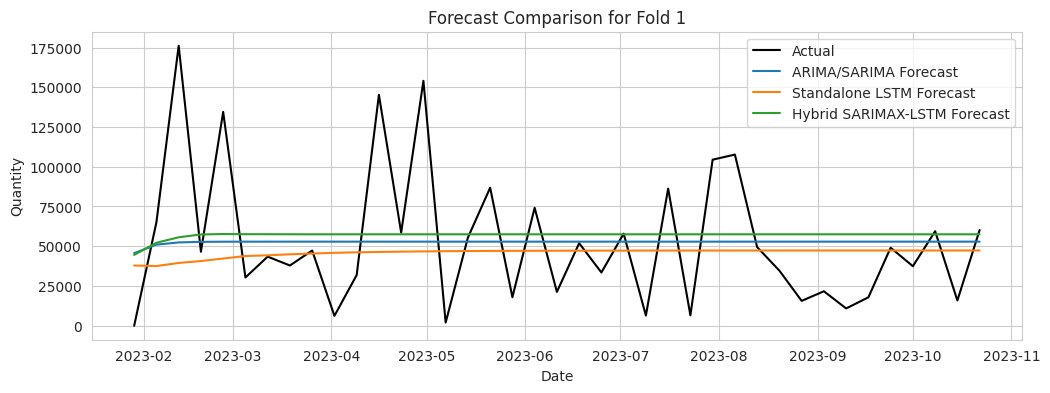

--- Visualizing forecasts for Fold 2/3 ---


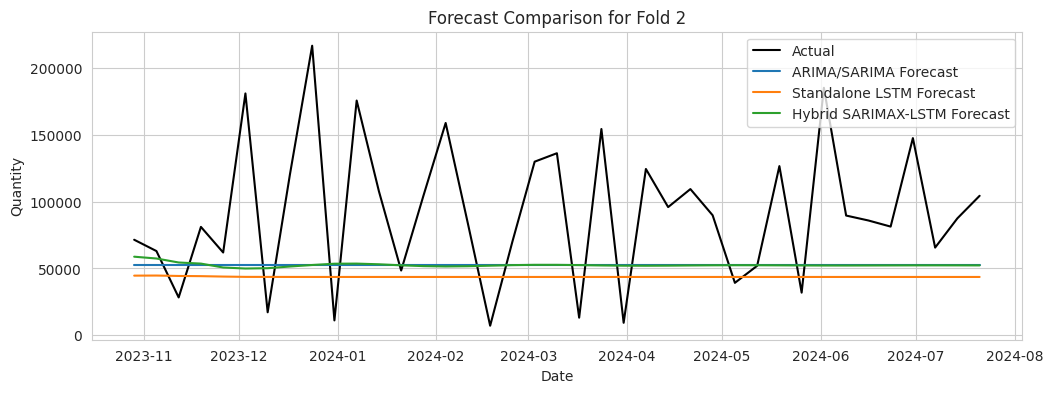

--- Visualizing forecasts for Fold 3/3 ---


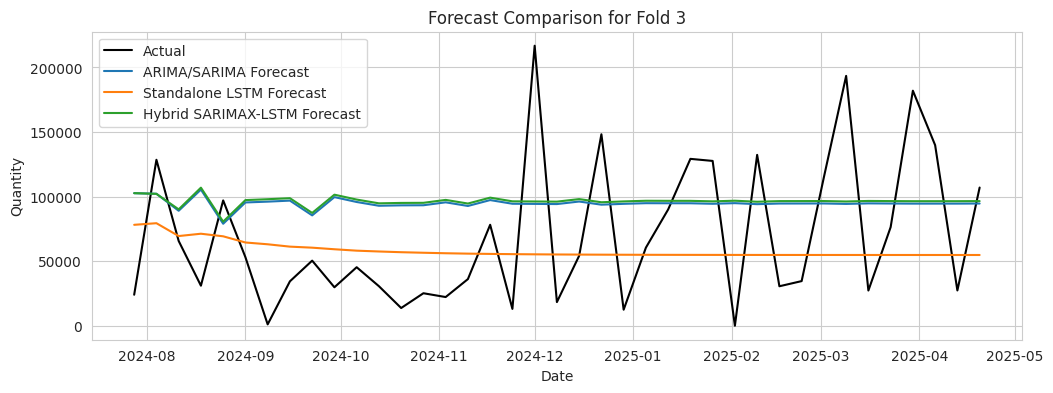


Time Series Cross-Validation forecast visualization complete.


In [149]:
# Ensure n_splits_eval and tscv_eval are defined from previous steps
if 'n_splits_eval' not in locals():
    n_splits_eval = 3 # Default if not set
    tscv_eval = TimeSeriesSplit(n_splits=n_splits_eval)
    print(f"Using TimeSeriesSplit with default n_splits_eval={n_splits_eval} for visualization.")
else:
    print(f"Using existing tscv_eval with n_splits_eval={n_splits_eval} for visualization.")

print("\nVisualizing forecasts for each fold of Time Series Cross-Validation...")

# Iterate through the splits again to visualize forecasts
for fold, (train_index, val_index) in enumerate(tscv_eval.split(df)):
    print(f"--- Visualizing forecasts for Fold {fold+1}/{n_splits_eval} ---")

    # Extract the actual values for the validation set in this fold
    fold_val_df = df.iloc[val_index].copy()

    # Ensure train set was large enough for modeling in this fold (same check as before)
    min_required_size_viz = max(lstm_seq_len, hybrid_lstm_seq_len) + 12 # Use same minimum
    if len(df.iloc[train_index]) < min_required_size_viz:
        print(f"  Skipping visualization for fold {fold+1}: Train set too small ({len(df.iloc[train_index])}).")
        continue # Skip to the next fold


    # Retrieve the corresponding forecast arrays from the lists
    # Need to check if the forecasts for this specific fold were successfully generated (i.e., not None)
    arima_preds_fold_viz = arima_forecasts_cv[fold] if fold < len(arima_forecasts_cv) else None
    lstm_preds_fold_viz  = lstm_forecasts_cv[fold] if fold < len(lstm_forecasts_cv) else None
    hybrid_preds_fold_viz= hybrid_sarimax_forecasts_cv[fold] if fold < len(hybrid_sarimax_forecasts_cv) else None


    # Check if at least one forecast is available for this fold
    if arima_preds_fold_viz is None and lstm_preds_fold_viz is None and hybrid_preds_fold_viz is None:
        print(f"  No forecasts available for fold {fold+1} to visualize. Skipping.")
        continue # Skip plotting for this fold

    # Create a new figure and axes for this fold's visualization
    plt.figure(figsize=(12, 4))

    # Plot the actual values
    plt.plot(fold_val_df['date'], fold_val_df['qty'], label='Actual', c='black')

    # Plot the retrieved forecast arrays if available
    if arima_preds_fold_viz is not None:
        plt.plot(fold_val_df['date'], arima_preds_fold_viz, label='ARIMA/SARIMA Forecast')

    if lstm_preds_fold_viz is not None:
        # Ensure lstm_preds_fold_viz is a numpy array or pandas Series for plotting
        plt.plot(fold_val_df['date'], lstm_preds_fold_viz, label='Standalone LSTM Forecast')

    if hybrid_preds_fold_viz is not None:
        # Ensure hybrid_preds_fold_viz is a numpy array or pandas Series for plotting
        plt.plot(fold_val_df['date'], hybrid_preds_fold_viz, label='Hybrid SARIMAX-LSTM Forecast')

    # Add title, legend, and labels
    plt.title(f"Forecast Comparison for Fold {fold+1}")
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()

print("\nTime Series Cross-Validation forecast visualization complete.")

/tmp/ipython-input-150-3055379047.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_results_sorted_by_mape.index, y='MAPE (%)', data=all_results_sorted_by_mape, palette='viridis') # Corrected typo here


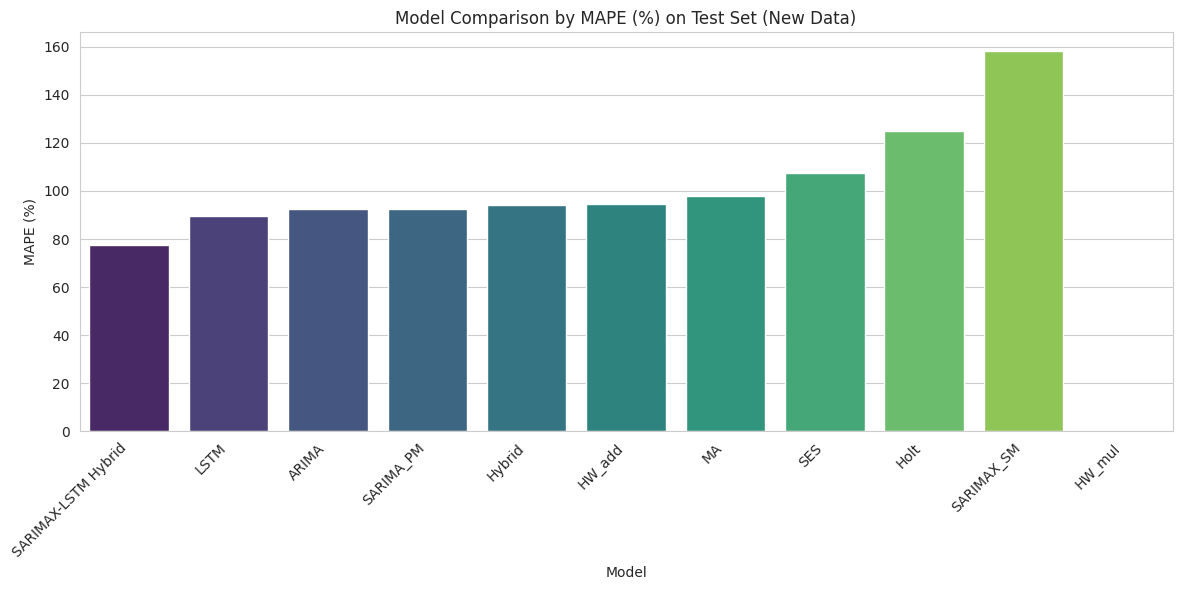

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure all_results_df is available from cell 6033ff5e
if 'all_results_df' in locals() and 'MAPE (%)' in all_results_df.columns:
    # Sort by MAPE for better visualization
    all_results_sorted_by_mape = all_results_df.sort_values('MAPE (%)')

    plt.figure(figsize=(12, 6))
    # Create a bar plot of MAPE (%)
    sns.barplot(x=all_results_sorted_by_mape.index, y='MAPE (%)', data=all_results_sorted_by_mape, palette='viridis') # Corrected typo here

    plt.title('Model Comparison by MAPE (%) on Test Set (New Data)')
    plt.xlabel('Model')
    plt.ylabel('MAPE (%)')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

    # Optional: You can also visualize MAE and RMSE similarly
    # plt.figure(figsize=(12, 6))
    # sns.barplot(x=all_results_sorted_by_mape.index, y='MAE', data=all_results_sorted_by_mape, palette='viridis')
    # plt.title('Model Comparison by MAE on Test Set (New Data)')
    # plt.xlabel('Model')
    # plt.ylabel('MAE')
    # plt.xticks(rotation=45, ha='right')
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(12, 6))
    # sns.barplot(x=all_results_sorted_by_mape.index, y='RMSE', data=all_results_sorted_by_mape, palette='viridis')
    # plt.title('Model Comparison by RMSE on Test Set (New Data)')
    # plt.xlabel('Model')
    # plt.ylabel('RMSE')
    # plt.xticks(rotation=45, ha='right')
    # plt.tight_layout()
    # plt.show()

else:
    print("DataFrame 'all_results_df' or 'MAPE (%)' column not found. Please run cell 6033ff5e first.")

In [151]:
# Combine the original results with the extended models results
# Ensure combined_results_df and kpi_df are available

if 'combined_results_df' in locals() and 'kpi_df' in locals():
    # Rename index of kpi_df to avoid conflict if necessary, or just concatenate
    # Let's assume index names are unique for now.
    all_results_df = pd.concat([combined_results_df, kpi_df])

    print("\nOverall Model Comparison (New Data):")
    # Display the combined table, sorted by MAPE (%)
    # Ensure MAPE (%) column exists and handle potential NaNs in sorting
    if 'MAPE (%)' in all_results_df.columns:
         display(all_results_df.round(2).sort_values('MAPE (%)'))
    else:
         display(all_results_df.round(2))
else:
    print("Required DataFrames (combined_results_df or kpi_df) not found for comparison.")

# Note: You might need to re-run the original evaluation cells (d349f2e5, jU06ICczkEnR)
# if combined_results_df was calculated based on the OLD data.
# Make sure all evaluation cells are run on the NEW data's train/test split before combining.


Overall Model Comparison (New Data):


,MAE,RMSE,MAPE (%)
SARIMAX-LSTM Hybrid,48577.98,69128.33,65.55
LSTM,47572.91,63687.31,80.48
ARIMA,48246.46,61727.43,92.44
SARIMA_PM,48006.11,61925.51,92.44
HW_add,53081.52,70203.67,94.76
Hybrid,48567.31,60640.84,99.90
SES,48675.82,59722.43,107.58
Holt,94811.66,123958.45,124.77
MA,51385.83,59273.96,133.04
SARIMAX_SM,52706.21,59164.11,158.03
